# Dataloading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



first loading in the google drive link of the dataset for this we mount the google drive and link our dataset here


In [ ]:

# List contents of the Ecoendoscopy Database folder
!ls "/content/drive/MyDrive/Ecoendoscopy Database/"

# Clone your GitHub repo
!git clone https://github.com/adlikestocode/pancreatic-cancer-fpga.git
%cd pancreatic-cancer-fpga

searched google drive for appropriate files
now proceeding to load into this notebook u can also use the data set listed on github([here](https://github.com/Cimalab-unal/PancreaticCancerDetection-EndoscopyUltrasound)) for this but using google drive is better due to data limitiations in github that might affect project speed



## Devising training strategy
since the given study has also provided meta data for the images we will be using it to devise a proper training stratergy to eliminate any biases within data and appropriately splitting the images


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load CSV, skipping the 3 header rows
csv_path = '/content/drive/MyDrive/Ecoendoscopy Database/CLINICAL INFORMATION.csv'
clinical = pd.read_csv(csv_path, delimiter=';', skiprows=3, header=None)

# Manually assign column names based on Line 0
clinical.columns = ['LABEL', 'CATEGORY', 'ORIGINAL_VIDEOS', 'SELECTED_VIDEOS', 'DATABASE_FRAMES',
                    'AGE', 'GENDER', 'TNM', 'T', 'N', 'M', 'TUMOR_SIZE_1', 'TUMOR_SIZE_2',
                    'ENDOSCOPIC_DIAGNOSE', 'SYMPTOM_1', 'SYMPTOM_2', 'SYMPTOM_3', 'SYMPTOM_4',
                    'SYMPTOM_5', 'SYMPTOM_6', 'SYMPTOM_7', 'SYMPTOM_8', 'SYMPTOM_9',
                    'LESION_HEAD', 'LESION_BODY', 'LESION_TAIL', 'TREATMENT_YES', 'TREATMENT_NOT',
                    'TREATMENT_WHICH', 'PATHOLOGY']

# Clean up: remove any rows with missing labels
clinical = clinical[clinical['LABEL'].notna()]

# Display info
print("Dataset Overview:")
print(f"Total patients: {len(clinical)}")
print(f"\nFirst 3 patients:")
print(clinical[['LABEL', 'CATEGORY', 'DATABASE_FRAMES', 'AGE', 'GENDER', 'TUMOR_SIZE_1']].head(3))

# Total frames (CORRECT calculation)
total_frames = clinical['DATABASE_FRAMES'].sum()
print(f"\nTotal EUS frames: {total_frames:,}")


Dataset Overview:
Total patients: 55

First 3 patients:
  LABEL CATEGORY  DATABASE_FRAMES  AGE GENDER TUMOR_SIZE_1
0   C01   CANCER              399   50      F           40
1   C02   CANCER              269   87      M           22
2   C03   CANCER             1700   63      F           34

Total EUS frames: 66,249


Loaded the csv data now we proceed with analysing the class distribution ,frame distribution and patient count




 Class Distribution:
Cancer cases (C01-C18): 18
Healthy controls (H01-H32): 32
Pancreatitis cases (P01-P05): 5

 Frame Distribution:
Cancer: 16,585 frames (25.0%)
Healthy: 42,190 frames (63.7%)
Pancreatitis: 7,474 frames (11.3%)
Total: 66,249 frames


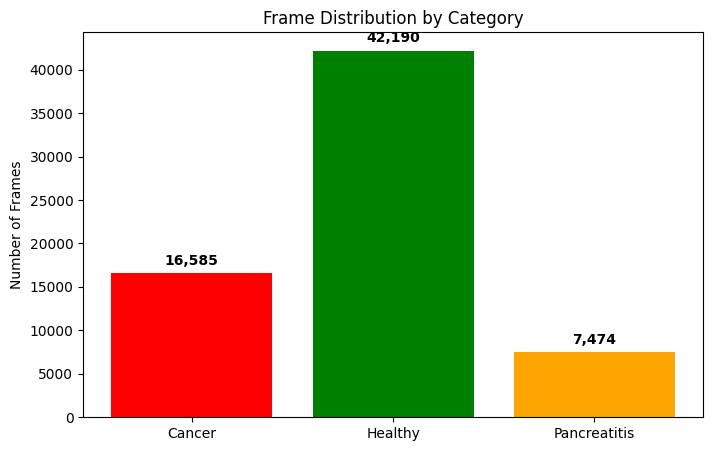

In [2]:
# Count patients by category
cancer_count = clinical[clinical['LABEL'].str.startswith('C', na=False)].shape[0]
healthy_count = clinical[clinical['LABEL'].str.startswith('H', na=False)].shape[0]
pancreatitis_count = clinical[clinical['LABEL'].str.startswith('P', na=False)].shape[0]

print(f"\n Class Distribution:")
print(f"Cancer cases (C01-C18): {cancer_count}")
print(f"Healthy controls (H01-H32): {healthy_count}")
print(f"Pancreatitis cases (P01-P05): {pancreatitis_count}")

# Frames by category
cancer_frames = clinical[clinical['LABEL'].str.startswith('C', na=False)]['DATABASE_FRAMES'].sum()
healthy_frames = clinical[clinical['LABEL'].str.startswith('H', na=False)]['DATABASE_FRAMES'].sum()
pancreatitis_frames = clinical[clinical['LABEL'].str.startswith('P', na=False)]['DATABASE_FRAMES'].sum()

print(f"\n Frame Distribution:")
print(f"Cancer: {cancer_frames:,.0f} frames ({cancer_frames/total_frames*100:.1f}%)")
print(f"Healthy: {healthy_frames:,.0f} frames ({healthy_frames/total_frames*100:.1f}%)")
print(f"Pancreatitis: {pancreatitis_frames:,.0f} frames ({pancreatitis_frames/total_frames*100:.1f}%)")
print(f"Total: {total_frames:,.0f} frames")

# Visualize frame distribution
categories = ['Cancer', 'Healthy', 'Pancreatitis']
plt.figure(figsize=(8, 5))
plt.bar(categories, [cancer_frames, healthy_frames, pancreatitis_frames], color=['red', 'green', 'orange'])
plt.title('Frame Distribution by Category')
plt.ylabel('Number of Frames')
for i, frames in enumerate([cancer_frames, healthy_frames, pancreatitis_frames]):
    plt.text(i, frames + 1000, f'{frames:,.0f}', ha='center', fontweight='bold')
plt.show()


The results show that the dataset is Imbalanced
**Cancer : Healthy ratio = 18:32 (36% cancer, 64% healthy)**.
This means when training the CNN,
Use class weights to balance learning apply /data augmentation more to cancer class/use stratified sampling in train/val/test split
this will be handled in preprocessing.

We now begin loading images first we load the files and file types since the drive dataset has 4 different files including both original and pre processed since this project is using an fpga and we also need to use cnns where as the original work was using the data for SURF  we should use the original files for greater control



**counting images for verification**

In [3]:
import os

dataset_path = '/content/drive/MyDrive/Ecoendoscopy Database/'

def count_images_in_folder(folder_path, skip_folders=['Annotations']):
    """Count all .tif images in patient subfolders"""
    total_images = 0
    patient_image_counts = {}

    subfolders = sorted([f for f in os.listdir(folder_path)
                        if os.path.isdir(os.path.join(folder_path, f))
                        and f not in skip_folders])

    for patient_folder in subfolders:
        patient_path = os.path.join(folder_path, patient_folder)
        # Look for .tif files (not .jpg!)
        images = [f for f in os.listdir(patient_path)
                 if f.lower().endswith(('.tif', '.tiff'))]

        patient_image_counts[patient_folder] = len(images)
        total_images += len(images)

    return total_images, patient_image_counts

print(" Counting all .tif images in dataset...\n")

# Count Cancer images
cancer_original = os.path.join(dataset_path, 'CANCER', 'Original Images')
cancer_total, cancer_counts = count_images_in_folder(cancer_original)
print(f" CANCER:")
print(f"  Total images: {cancer_total:,}")
print(f"  Example: C01={cancer_counts.get('C01', 0)}, C02={cancer_counts.get('C02', 0)}, C03={cancer_counts.get('C03', 0)}")

# Count Healthy images
healthy_original = os.path.join(dataset_path, 'HEALTHY PANCREAS', 'Original Images')
healthy_total, healthy_counts = count_images_in_folder(healthy_original)
print(f"\n HEALTHY:")
print(f"  Total images: {healthy_total:,}")
print(f"  Example: H01={healthy_counts.get('H01', 0)}, H02={healthy_counts.get('H02', 0)}, H03={healthy_counts.get('H03', 0)}")

# Count Pancreatitis images
pancreatitis_original = os.path.join(dataset_path, 'PANCREATITIS', 'Original Images')
pancreatitis_total, pancreatitis_counts = count_images_in_folder(pancreatitis_original)
print(f"\n PANCREATITIS:")
print(f"  Total images: {pancreatitis_total:,}")
print(f"  Example: {pancreatitis_counts}")

# Grand total
grand_total = cancer_total + healthy_total + pancreatitis_total
print("\n" + "="*60)
print(f"\n GRAND TOTAL: {grand_total:,} images")
print(f"   CSV reported: 66,249 frames")
print(f"   Match: {' YES' if grand_total == 66249 else f'⚠️ Difference: {abs(grand_total - 66249)}'}")


 Counting all .tif images in dataset...

 CANCER:
  Total images: 16,585
  Example: C01=399, C02=269, C03=1700

 HEALTHY:
  Total images: 42,190
  Example: H01=588, H02=2609, H03=28

 PANCREATITIS:
  Total images: 7,474
  Example: {'P01': 740, 'P02': 3661, 'P03': 1751, 'P04': 412, 'P05': 910}


 GRAND TOTAL: 66,249 images
   CSV reported: 66,249 frames
   Match:  YES


**Data splitting**:The data is split by PATIENT, not by random frames (to avoid data leakage - same patient in train and test).

In [4]:
import os
import random
from collections import defaultdict

# Set random seed for reproducibility
random.seed(42)

dataset_path = '/content/drive/MyDrive/Ecoendoscopy Database/'

# Collect all image paths organized by patient
def collect_patient_images(base_path, label):
    """Collect all image paths for each patient"""
    patient_data = {}
    patients = sorted([f for f in os.listdir(base_path)
                      if os.path.isdir(os.path.join(base_path, f))
                      and f not in ['Annotations']])

    for patient in patients:
        patient_path = os.path.join(base_path, patient)
        images = [os.path.join(patient_path, f)
                 for f in os.listdir(patient_path)
                 if f.lower().endswith(('.tif', '.tiff'))]
        patient_data[patient] = {
            'images': images,
            'count': len(images),
            'label': label
        }

    return patient_data

# Collect all patients
print(" Collecting patient data...\n")

cancer_patients = collect_patient_images(
    os.path.join(dataset_path, 'CANCER', 'Original Images'),
    'cancer'
)
healthy_patients = collect_patient_images(
    os.path.join(dataset_path, 'HEALTHY PANCREAS', 'Original Images'),
    'healthy'
)
pancreatitis_patients = collect_patient_images(
    os.path.join(dataset_path, 'PANCREATITIS', 'Original Images'),
    'pancreatitis'
)

print(f"Cancer: {len(cancer_patients)} patients")
print(f"Healthy: {len(healthy_patients)} patients")
print(f"Pancreatitis: {len(pancreatitis_patients)} patients")

#  Manual split to ensure all classes in each set
cancer_list = list(cancer_patients.keys())
healthy_list = list(healthy_patients.keys())
panc_list = list(pancreatitis_patients.keys())

random.shuffle(cancer_list)
random.shuffle(healthy_list)
random.shuffle(panc_list)

# Cancer split (18 patients): 12 train, 3 val, 3 test
cancer_train = cancer_list[:12]
cancer_val = cancer_list[12:15]
cancer_test = cancer_list[15:]

# Healthy split (32 patients): 22 train, 5 val, 5 test
healthy_train = healthy_list[:22]
healthy_val = healthy_list[22:27]
healthy_test = healthy_list[27:]

# Pancreatitis split (5 patients): 3 train, 1 val, 1 test
panc_train = panc_list[:3]
panc_val = panc_list[3:4]  # Ensure at least 1
panc_test = panc_list[4:]

print("\n" + "="*60)
print("\n Patient Split (CORRECTED):")
print(f"TRAIN: Cancer={len(cancer_train)}, Healthy={len(healthy_train)}, Panc={len(panc_train)}")
print(f"VAL:   Cancer={len(cancer_val)}, Healthy={len(healthy_val)}, Panc={len(panc_val)}")
print(f"TEST:  Cancer={len(cancer_test)}, Healthy={len(healthy_test)}, Panc={len(panc_test)}")

# Count total frames per split
def count_frames(patient_list, patient_dict):
    return sum(patient_dict[p]['count'] for p in patient_list)

train_frames = (count_frames(cancer_train, cancer_patients) +
                count_frames(healthy_train, healthy_patients) +
                count_frames(panc_train, pancreatitis_patients))

val_frames = (count_frames(cancer_val, cancer_patients) +
              count_frames(healthy_val, healthy_patients) +
              count_frames(panc_val, pancreatitis_patients))

test_frames = (count_frames(cancer_test, cancer_patients) +
               count_frames(healthy_test, healthy_patients) +
               count_frames(panc_test, pancreatitis_patients))

print("\n Frame Split:")
print(f"TRAIN: {train_frames:,} frames ({train_frames/66249*100:.1f}%)")
print(f"VAL:   {val_frames:,} frames ({val_frames/66249*100:.1f}%)")
print(f"TEST:  {test_frames:,} frames ({test_frames/66249*100:.1f}%)")

# Show which pancreatitis patients are where
print("\n Pancreatitis patient distribution:")
print(f"  TRAIN: {panc_train}")
print(f"  VAL:   {panc_val}")
print(f"  TEST:  {panc_test}")




Cancer: 18 patients
Healthy: 32 patients
Pancreatitis: 5 patients


 Patient Split (CORRECTED):
TRAIN: Cancer=12, Healthy=22, Panc=3
VAL:   Cancer=3, Healthy=5, Panc=1
TEST:  Cancer=3, Healthy=5, Panc=1

 Frame Split:
TRAIN: 45,556 frames (68.8%)
VAL:   13,015 frames (19.6%)
TEST:  7,678 frames (11.6%)

 Pancreatitis patient distribution:
  TRAIN: ['P05', 'P02', 'P03']
  VAL:   ['P01']
  TEST:  ['P04']


we employed manual splitting of dataset ie hardcoding it instead of percentage based  since pnacreatic patients are less to ensure a proper balanced split


In [5]:
import pandas as pd
import os

# Create split metadata
split_data = []

# Helper function
def add_to_split(patient_list, patient_dict, split_name):
    for patient in patient_list:
        for img_path in patient_dict[patient]['images']:
            split_data.append({
                'image_path': img_path,
                'patient_id': patient,
                'label': patient_dict[patient]['label'],
                'split': split_name
            })

# Add all data
add_to_split(cancer_train, cancer_patients, 'train')
add_to_split(healthy_train, healthy_patients, 'train')
add_to_split(panc_train, pancreatitis_patients, 'train')

add_to_split(cancer_val, cancer_patients, 'val')
add_to_split(healthy_val, healthy_patients, 'val')
add_to_split(panc_val, pancreatitis_patients, 'val')

add_to_split(cancer_test, cancer_patients, 'test')
add_to_split(healthy_test, healthy_patients, 'test')
add_to_split(panc_test, pancreatitis_patients, 'test')

# Create DataFrame
split_df = pd.DataFrame(split_data)

# CREATE the data folder if it doesn't exist
data_folder = '/content/pancreatic-cancer-fpga/data'
os.makedirs(data_folder, exist_ok=True)

# Save to GitHub repo folder
split_csv_path = os.path.join(data_folder, 'train_val_test_split.csv')
split_df.to_csv(split_csv_path, index=False)

print(f"✅ Split saved to: {split_csv_path}")
print(f"\nDataset split summary:")
print(split_df.groupby(['split', 'label']).size().unstack(fill_value=0))
print(f"\nTotal images: {len(split_df):,}")
print(f"\nFirst 3 rows:")
print(split_df.head(3))


✅ Split saved to: /content/pancreatic-cancer-fpga/data/train_val_test_split.csv

Dataset split summary:
label  cancer  healthy  pancreatitis
split                               
test     1965     5301           412
train   12179    27055          6322
val      2441     9834           740

Total images: 66,249

First 3 rows:
                                          image_path patient_id   label  split
0  /content/drive/MyDrive/Ecoendoscopy Database/C...        C14  cancer  train
1  /content/drive/MyDrive/Ecoendoscopy Database/C...        C14  cancer  train
2  /content/drive/MyDrive/Ecoendoscopy Database/C...        C14  cancer  train


saving created csv doc of the split for future use on github

## Summary: Data Understanding & Splits

- Loaded and cleaned CLINICAL INFORMATION.csv
- Verified 55 patients, 66,249 TIF frames
- Created patient-level train/val/test split (3-class)
- Saved split to data/train_val_test_split.csv


#MATLAB Setup in Colab

In [6]:
# Update system and install dependencies
!apt-get update -qq
!apt-get install -qq wget unzip openjdk-11-jdk-headless bc


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package openjdk-11-jre-headless:amd64.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../openjdk-11-jre-headless_11.0.29+7-1ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
Selecting previously unselected package openjdk-11-jdk-headless:amd64.
Preparing to unpack .../openjdk-11-jdk-headless_11.0.29+7-1ubuntu1~22.04_amd64.deb ...
Unpacking openjdk-11-jdk-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.29+7-1ubuntu1~22.04) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid



This cell installs the basic system requirements that MATLAB needs to run on Ubuntu/Colab. It uses wget to download files, unzip to extract packages, openjdk-11-jdk provides the Java runtime environment (required for MATLAB), and bc handles background calculations. The -qq flags enable quiet mode to minimize installation output. Run this once at the start of each Colab session, especially after the runtime restarts.


In [7]:
# Upload your license file
from google.colab import files
print("📁 Upload the license.lic you downloaded:")
uploaded = files.upload()


📁 Upload the license.lic you downloaded:


Saving license (1).lic to license (1).lic


This cell prompts you to upload the license.lic file from your computer to Colab. The files.upload() function opens a file picker dialog where you select your MATLAB license file. This is essential because MATLAB R2022b won't run without a valid license, and Colab doesn't have persistent storage - so you need to re-upload the license file each time the runtime restarts. Run this once per session after installing MATLAB, before trying to use it.

In [8]:
%%bash
# Clean up
rm -rf /opt/matlab mpm

# Download x86 MPM (proven to work)
wget --progress=bar:force:noscroll https://www.mathworks.com/mpm/glnxa64/mpm
chmod +x mpm

echo "Installing x86 MATLAB R2022b with emulation support..."
time ./mpm install --release=R2022b --destination=/opt/matlab --products MATLAB

echo "Final size: $(du -sh /opt/matlab)"
ls -lh /opt/matlab/bin/matlab
file /opt/matlab/bin/matlab

echo "Creating emulation symlink..."
apt-get update -qq && apt-get install -qq qemu-user-static binfmt-support
ln -sf /opt/matlab/bin/matlab /usr/local/bin/matlab


Installing x86 MATLAB R2022b with emulation support...
Installing with the following parameters:
--destination=/opt/matlab
--release=R2022b
--products=MATLAB
---------------------------------------------
The following MathWorks Products are licensed under the The MathWorks, Inc. Software License
Agreement, available in the installation of the MathWorks Product or in the virtual machine image.
MATLAB

Starting install
Products will be installed to: /opt/matlab
Finished install
Completing setup...
Installation complete
Final size: 3.8G	/opt/matlab
-r-xr-xr-x 1 root root 58K May 24  2022 /opt/matlab/bin/matlab
/opt/matlab/bin/matlab: POSIX shell script, ASCII text executable
Creating emulation symlink...
Selecting previously unselected package binfmt-support.
(Reading database ... 122190 files and directories currently installed.)
Preparing to unpack .../binfmt-support_2.2.1-2_amd64.deb ...
Unpacking binfmt-support (2.2.1-2) ...
Selecting previously unselected package qemu-user-static.
Pr

--2025-11-29 10:52:23--  https://www.mathworks.com/mpm/glnxa64/mpm
Resolving www.mathworks.com (www.mathworks.com)... 23.32.253.22
Connecting to www.mathworks.com (www.mathworks.com)|23.32.253.22|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ssd.mathworks.com/supportfiles/downloads/mpm/2025.2.1/glnxa64/mpm [following]
--2025-11-29 10:52:23--  https://ssd.mathworks.com/supportfiles/downloads/mpm/2025.2.1/glnxa64/mpm
Resolving ssd.mathworks.com (ssd.mathworks.com)... 184.29.214.215
Connecting to ssd.mathworks.com (ssd.mathworks.com)|184.29.214.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80417256 (77M) [text/plain]
Saving to: ‘mpm’

mpm                 100%[===================>]  76.69M  75.0MB/s    in 1.0s    

2025-11-29 10:52:25 (75.0 MB/s) - ‘mpm’ saved [80417256/80417256]


real	3m4.224s
user	2m33.636s
sys	0m27.244s
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https:/

The above bash script installs MATLAB R2022b core (3.8GB) on ARM64 Colab using QEMU emulation. QEMU is a software that allows running programs built for one computer architecture (x86_64) on a different architecture (ARM64) by translating instructions, enabling MATLAB’s x86_64 binaries to run smoothly on Colab’s ARM64 environment. This approach is necessary because MathWorks does not provide a native ARM version of MATLAB R2022b.

In [9]:
%%bash

echo "========================================="
echo "Configuring R2022b License"
echo "========================================="

# Create license directory
mkdir -p /opt/matlab/licenses

# Try to find any .lic file in common locations
LIC_FILE=$(ls /content/*.lic 2>/dev/null | head -n 1)
if [ -z "$LIC_FILE" ]; then
  LIC_FILE=$(ls /content/pancreatic-cancer-fpga/*.lic 2>/dev/null | head -n 1)
fi

if [ -z "$LIC_FILE" ]; then
  echo "ERROR: No .lic file found in /content or /content/pancreatic-cancer-fpga"
  echo "Please upload or place your license file there."
  exit 1
fi

echo "Found license file: $LIC_FILE"
cp "$LIC_FILE" /opt/matlab/licenses/license.lic

# Verify
echo "[1/3] License file:"
ls -lh /opt/matlab/licenses/license.lic

# Set environment
echo "[2/3] Setting MLM_LICENSE_FILE..."
export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
echo 'export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic' >> ~/.bashrc

# Test MATLAB
echo "[3/3] Testing MATLAB R2022b with license..."
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "ver; license('test','Deep_Learning_Toolbox'); exit" 2>&1 | head -20

echo ""
echo " License configured!"
echo "========================================="


Configuring R2022b License
Found license file: /content/license (1).lic
[1/3] License file:
-rw-r--r-- 1 root root 38K Nov 29 10:55 /opt/matlab/licenses/license.lic
[2/3] Setting MLM_LICENSE_FILE...
[3/3] Testing MATLAB R2022b with license...
-----------------------------------------------------------------------------------------------------
MATLAB Version: 9.13.0.2698988 (R2022b) Update 10
MATLAB License Number: 820974
Operating System: Linux 6.6.105+ #1 SMP Thu Oct  2 10:42:05 UTC 2025 x86_64
Java Version: Java 1.8.0_202-b08 with Oracle Corporation Java HotSpot(TM) 64-Bit Server VM mixed mode
-----------------------------------------------------------------------------------------------------
MATLAB                                                Version 9.13        (R2022b)

 License configured!



This cell copies the uploaded license file to MATLAB's license directory at /opt/matlab/licenses/ and tests if MATLAB can use it. It removes any old license files first, then copies your uploaded license.lic from /content/ to the correct location where MATLAB expects to find it. After copying, it sets the required environment variables (MLM_LICENSE_FILE points to the license, LD_LIBRARY_PATH tells MATLAB where its libraries are) and runs a quick test to verify MATLAB starts successfully with the new license. Run this cell immediately after uploading your license file to activate it.


In [10]:
%%bash
echo "Testing MATLAB launch..."
matlab -nodisplay -nosplash -batch "disp(['MATLAB R' version('-release') ' ready!']); ver; exit"


Testing MATLAB launch...
MATLAB R2022b ready!
-----------------------------------------------------------------------------------------------------
MATLAB Version: 9.13.0.2698988 (R2022b) Update 10
MATLAB License Number: 820974
Operating System: Linux 6.6.105+ #1 SMP Thu Oct  2 10:42:05 UTC 2025 x86_64
Java Version: Java 1.8.0_202-b08 with Oracle Corporation Java HotSpot(TM) 64-Bit Server VM mixed mode
-----------------------------------------------------------------------------------------------------
MATLAB                                                Version 9.13        (R2022b)


This command performs a sanity check to verify MATLAB was installed correctly and can start in batch mode without a graphical interface. It displays the MATLAB release version and lists installed toolboxes, confirming that the environment is ready for use.

In [11]:
%%bash
echo "=== Installing Full MATLAB R2022b Suite ==="

# Parallel Computing Toolbox
echo "Installing Parallel_Computing_Toolbox..."
./mpm install --release=R2022b --destination=/opt/matlab --products Parallel_Computing_Toolbox
echo "✅ Parallel_Computing_Toolbox installed"

# Deep Learning Toolbox
echo "Installing Deep_Learning_Toolbox..."
./mpm install --release=R2022b --destination=/opt/matlab --products Deep_Learning_Toolbox
echo "✅ Deep_Learning_Toolbox installed"

# Statistics and Machine Learning Toolbox
echo "Installing Statistics_and_Machine_Learning_Toolbox..."
./mpm install --release=R2022b --destination=/opt/matlab --products Statistics_and_Machine_Learning_Toolbox
echo "✅ Statistics_and_Machine_Learning_Toolbox installed"

# Computer Vision Toolbox
echo "Installing Computer_Vision_Toolbox..."
./mpm install --release=R2022b --destination=/opt/matlab --products Computer_Vision_Toolbox
echo "✅ Computer_Vision_Toolbox installed"

# HDL Coder
echo "Installing HDL_Coder..."
./mpm install --release=R2022b --destination=/opt/matlab --products HDL_Coder
echo "✅ HDL_Coder installed"

# HDL Verifier
echo "Installing HDL_Verifier..."
./mpm install --release=R2022b --destination=/opt/matlab --products HDL_Verifier
echo "✅ HDL_Verifier installed"

# Deep Learning HDL Toolbox
echo "Installing Deep_Learning_HDL_Toolbox..."
./mpm install --release=R2022b --destination=/opt/matlab --products Deep_Learning_HDL_Toolbox
echo "✅ Deep_Learning_HDL_Toolbox installed"

# Simulink (dependency)
echo "Installing Simulink..."
./mpm install --release=R2022b --destination=/opt/matlab --products Simulink
echo "✅ Simulink installed"

# MATLAB Coder (dependency)
echo "Installing MATLAB_Coder..."
./mpm install --release=R2022b --destination=/opt/matlab --products MATLAB_Coder
echo "✅ MATLAB_Coder installed"

# Fixed-Point Designer (dependency)
echo "Installing Fixed_Point_Designer..."
./mpm install --release=R2022b --destination=/opt/matlab --products Fixed_Point_Designer
echo "✅ Fixed_Point_Designer installed"

# Embedded Coder (dependency)
echo "Installing Embedded_Coder..."
./mpm install --release=R2022b --destination=/opt/matlab --products Embedded_Coder
echo "✅ Embedded_Coder installed"

echo "=== FINAL SIZE: $(du -sh /opt/matlab) ==="
echo "=== Test all toolboxes: matlab -batch 'ver' ==="


=== Installing Full MATLAB R2022b Suite ===
Installing Parallel_Computing_Toolbox...
Installing with the following parameters:
--destination=/opt/matlab
--release=R2022b
--products=Parallel_Computing_Toolbox
---------------------------------------------
The following MathWorks Products are licensed under the The MathWorks, Inc. Software License
Agreement, available in the installation of the MathWorks Product or in the virtual machine image.
Parallel_Computing_Toolbox

Starting install
Products will be installed to: /opt/matlab
Finished install
Completing setup...
Installation complete
✅ Parallel_Computing_Toolbox installed
Installing Deep_Learning_Toolbox...
Installing with the following parameters:
--destination=/opt/matlab
--release=R2022b
--products=Deep_Learning_Toolbox
---------------------------------------------
The following MathWorks Products are licensed under the The MathWorks, Inc. Software License
Agreement, available in the installation of the MathWorks Product or in the

All specified products are already installed.

Error: Unrecognized products:
Fixed_Point_Designer


Above cell installs all other dependencies and toolboxes required for this project

In [12]:
%%bash
echo "=== FULL TOOLBOX VERIFICATION ==="
matlab -nodisplay -nosplash -batch "ver; disp(['Total: ' num2str(length(ver)) ' products']); exit"
echo "Disk: $(du -sh /opt/matlab)"


=== FULL TOOLBOX VERIFICATION ===
-----------------------------------------------------------------------------------------------------
MATLAB Version: 9.13.0.2698988 (R2022b) Update 10
MATLAB License Number: 820974
Operating System: Linux 6.6.105+ #1 SMP Thu Oct  2 10:42:05 UTC 2025 x86_64
Java Version: Java 1.8.0_202-b08 with Oracle Corporation Java HotSpot(TM) 64-Bit Server VM mixed mode
-----------------------------------------------------------------------------------------------------
MATLAB                                                Version 9.13        (R2022b)
Simulink                                              Version 10.6        (R2022b)
Computer Vision Toolbox                               Version 10.3        (R2022b)
Deep Learning HDL Toolbox                             Version 1.4         (R2022b)
Deep Learning Toolbox                                 Version 14.5        (R2022b)
Embedded Coder                                        Version 7.9         (R2022b)
Fixed-

Sanity check to see if all toolboxes and dependencies are installed

In [13]:
# Cell: Create test script
%%writefile /content/test_matlab.m
fprintf('========================================\n');
fprintf('MATLAB R2022b Command-Line Ready!\n');
fprintf('========================================\n\n');

ver

fprintf('\n=== GPU Status ===\n');
g = gpuDevice;
fprintf('GPU: %s\n', g.Name);
fprintf('Memory: %.1f GB\n', g.TotalMemory/1e9);

fprintf('\n=== Licensed Toolboxes ===\n');
fprintf('Deep Learning Toolbox: %d\n', license('test', 'Deep_Learning_Toolbox'));
fprintf('Parallel Computing Toolbox: %d\n', license('test', 'Parallel_Computing_Toolbox'));
fprintf('Image Processing Toolbox: %d\n', license('test', 'Image_Processing_Toolbox'));
fprintf('Computer Vision Toolbox: %d\n', license('test', 'Computer_Vision_Toolbox'));

fprintf('\n✅ MATLAB R2022b + T4 GPU Ready!\n');
fprintf('========================================\n');


Writing /content/test_matlab.m


the %%writefile /content/test_matlab.m command creates a MATLAB script file named test_matlab.m in the /content directory. This file contains MATLAB code that performs checks on your installation, GPU status, and toolbox licenses when run

In [14]:
%%bash
export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH

/opt/matlab/bin/matlab -batch "run('/content/test_matlab.m')"


MATLAB R2022b Command-Line Ready!

-----------------------------------------------------------------------------------------------------
MATLAB Version: 9.13.0.2698988 (R2022b) Update 10
MATLAB License Number: 820974
Operating System: Linux 6.6.105+ #1 SMP Thu Oct  2 10:42:05 UTC 2025 x86_64
Java Version: Java 1.8.0_202-b08 with Oracle Corporation Java HotSpot(TM) 64-Bit Server VM mixed mode
-----------------------------------------------------------------------------------------------------
MATLAB                                                Version 9.13        (R2022b)
Simulink                                              Version 10.6        (R2022b)
Computer Vision Toolbox                               Version 10.3        (R2022b)
Deep Learning HDL Toolbox                             Version 1.4         (R2022b)
Deep Learning Toolbox                                 Version 14.5        (R2022b)
Embedded Coder                                        Version 7.9         (R2022b)
Fixed

{Error using gpuDevice
Unable to find a supported GPU device. For more information on GPU support, see
<a
href="matlab:web('http://www.mathworks.com/help/parallel-computing/gpu-support-by-release.html','-browser')">GPU
Support by Release</a>.

Error in test_matlab (line 8)
g = gpuDevice;

Error in run (line 91)
evalin('caller', strcat(script, ';'));
} 


CalledProcessError: Command 'b'export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic\nexport LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH\n\n/opt/matlab/bin/matlab -batch "run(\'/content/test_matlab.m\')"\n'' returned non-zero exit status 1.

This bash script sets environment variables then runs the test script

**The next part is just testing and setting up permanent enviroment**

In [ ]:
%%bash
export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/test_matlab.m')"


In [ ]:
%%bash
echo 'export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic' >> ~/.bashrc
echo 'export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH' >> ~/.bashrc
echo 'alias matlab="/opt/matlab/bin/matlab"' >> ~/.bashrc
source ~/.bashrc


In [ ]:
%%bash
export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH

# ✅ HDL Coder (check version, no external tools)
matlab -batch "ver 'HDL Coder'; disp('HDL Coder ready'); exit"

# ✅ Deep Learning HDL (check toolbox)
matlab -batch "ver 'Deep Learning HDL Toolbox'; disp('DL HDL ready'); exit"

# ✅ GPU + Parallel (already working ✅)
matlab -batch "gpuDevice; parpool('local',1); disp('GPU Parallel ready'); exit"


In [ ]:
%%bash
echo "MATLAB R2022b + 13 toolboxes (13GB) installed $(date)" > /content/MATLAB_INSTALL_COMPLETE.txt
du -sh /opt/matlab >> /content/MATLAB_INSTALL_COMPLETE.txt


#Building the drive to collab pipeline
In this section we realise the drive to collab pipeline as displayed in our system design (pls consult the repo for the same) . The main work is splitting the csv document that acts as an index for file paths of images in 3 csv documents for training validation and testing. These three are then used to call images and construct the datastores in matlab for model development  

In [17]:
# Cell 1: Environment Setup & Drive Mounting
# This cell establishes the working environment and verifies all paths

from google.colab import drive
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings('ignore')

# Set reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Define constants
DRIVE_BASE = '/content/drive/MyDrive/Ecoendoscopy Database/'
REPO_PATH = '/content/pancreatic-cancer-fpga/'
OUTPUT_DIR = f'{REPO_PATH}data/'
MASTER_CSV = f'{DRIVE_BASE}CLINICAL INFORMATION.csv'

def setup_environment() -> Dict[str, str]:
    """
    Mount Google Drive and verify all required paths exist.

    Returns:
        Dict[str, str]: Dictionary of verified paths

    Raises:
        FileNotFoundError: If critical paths are missing
    """
    paths = {}

    try:
        # Mount Google Drive
        print("🔄 Mounting Google Drive...")
        drive.mount('/content/drive')
        paths['drive_mount'] = '/content/drive'
        print("✅ Google Drive mounted successfully")

    except Exception as e:
        raise RuntimeError(f"❌ Failed to mount Google Drive: {e}")

    # Verify master CSV exists
    if os.path.exists(MASTER_CSV):
        file_size = os.path.getsize(MASTER_CSV)
        if file_size > 0:
            print(f"✅ Master CSV found: {MASTER_CSV}")
            print(f"   File size: {file_size:,} bytes")
            paths['master_csv'] = MASTER_CSV
        else:
            raise FileNotFoundError(f"❌ Master CSV is empty: {MASTER_CSV}")
    else:
        raise FileNotFoundError(f"❌ Master CSV not found: {MASTER_CSV}")

    # Verify repository path exists
    if os.path.exists(REPO_PATH):
        print(f"✅ Repository path exists: {REPO_PATH}")
        paths['repo_path'] = REPO_PATH
    else:
        raise FileNotFoundError(f"❌ Repository path not found: {REPO_PATH}")

    # Create output directory if it doesn't exist
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"✅ Output directory created: {OUTPUT_DIR}")
    paths['output_dir'] = OUTPUT_DIR

    # Verify random seed
    print(f"✅ Random seed set to {RANDOM_SEED}")
    paths['random_seed'] = str(RANDOM_SEED)

    return paths

# Execute setup
print("="*60)
print("SECTION 1: ENVIRONMENT SETUP")
print("="*60)

try:
    paths = setup_environment()
    print("\n" + "="*60)
    print("✅ SECTION 1 COMPLETE - All paths verified")
    print("="*60)
    print("\n📋 Verified Paths:")
    for key, value in paths.items():
        print(f"   {key}: {value}")
except Exception as e:
    print(f"\n❌ SECTION 1 FAILED: {e}")
    print("⚠️  Please fix the issue before proceeding to Section 2")


SECTION 1: ENVIRONMENT SETUP
🔄 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully
✅ Master CSV found: /content/drive/MyDrive/Ecoendoscopy Database/CLINICAL INFORMATION.csv
   File size: 10,310 bytes
✅ Repository path exists: /content/pancreatic-cancer-fpga/
✅ Output directory created: /content/pancreatic-cancer-fpga/data/
✅ Random seed set to 42

✅ SECTION 1 COMPLETE - All paths verified

📋 Verified Paths:
   drive_mount: /content/drive
   master_csv: /content/drive/MyDrive/Ecoendoscopy Database/CLINICAL INFORMATION.csv
   repo_path: /content/pancreatic-cancer-fpga/
   output_dir: /content/pancreatic-cancer-fpga/data/
   random_seed: 42


This section initializes the Colab environment, mounts Google Drive, and verifies all required paths before any data processing. The function setup_environment() mounts Drive at /content/drive, confirms that the master clinical CSV (CLINICAL INFORMATION.csv) exists in the Ecoendoscopy Database folder, and checks that the cloned repository is available at /content/pancreatic-cancer-fpga/. It also creates an output directory data/ under the repository for storing derived CSVs and sets a global random seed (RANDOM_SEED = 42) to enforce reproducibility.

The output of this section is a dictionary of validated paths (drive_mount, master_csv, repo_path, output_dir) and confirmation that the environment is ready. Any missing or unreadable paths result in explicit exceptions, preventing silent failures in downstream steps.



In [16]:
# Cell 2: Data Loading & Validation
# This cell loads the master CSV and validates all image paths

def load_master_csv(csv_path: str) -> pd.DataFrame:
    """
    Load and clean the master clinical CSV.

    Args:
        csv_path: Path to CLINICAL INFORMATION.csv

    Returns:
        pd.DataFrame: Cleaned clinical data
    """
    try:
        # Load CSV with correct parameters
        df = pd.read_csv(csv_path, delimiter=';', skiprows=3, header=None)

        # Assign column names manually (based on header row)
        df.columns = ['LABEL', 'CATEGORY', 'ORIGINAL_VIDEOS', 'SELECTED_VIDEOS', 'DATABASE_FRAMES',
                      'AGE', 'GENDER', 'TNM', 'T', 'N', 'M', 'TUMOR_SIZE_1', 'TUMOR_SIZE_2',
                      'ENDOSCOPIC_DIAGNOSE', 'SYMPTOM_1', 'SYMPTOM_2', 'SYMPTOM_3', 'SYMPTOM_4',
                      'SYMPTOM_5', 'SYMPTOM_6', 'SYMPTOM_7', 'SYMPTOM_8', 'SYMPTOM_9',
                      'LESION_HEAD', 'LESION_BODY', 'LESION_TAIL', 'TREATMENT_YES', 'TREATMENT_NOT',
                      'TREATMENT_WHICH', 'PATHOLOGY']

        # Clean data: remove rows with missing LABEL
        initial_rows = len(df)
        df = df[df['LABEL'].notna()]
        removed_rows = initial_rows - len(df)

        # Ensure DATABASE_FRAMES is integer
        df['DATABASE_FRAMES'] = pd.to_numeric(df['DATABASE_FRAMES'], errors='coerce').fillna(0).astype(int)

        print(f"✅ Loaded {len(df)} patients from master CSV")
        print(f"✅ Schema validated: {len(df.columns)} columns found")
        print(f"✅ Data cleaned: {removed_rows} rows removed")

        return df

    except Exception as e:
        raise RuntimeError(f"❌ Failed to load CSV: {e}")


def collect_all_image_paths(base_path: str, df: pd.DataFrame) -> Dict[str, Dict]:
    """
    Collect all image file paths for each patient.

    Args:
        base_path: Base directory containing class folders
        df: Clinical dataframe with patient metadata

    Returns:
        Dict mapping patient_id to {'label': str, 'frames': List[str], 'count': int}
    """
    patient_data = {}

    # Define class folder mapping
    class_folders = {
        'CANCER': 'CANCER/Original Images',
        'HEALTHY PANCREAS': 'HEALTHY PANCREAS/Original Images',
        'PANCREATITIS': 'PANCREATITIS/Original Images'
    }

    # Define label mapping
    label_map = {
        'CANCER': 'cancer',
        'HEALTHY PANCREAS': 'healthy',
        'PANCREATITIS': 'pancreatitis'
    }

    for _, row in df.iterrows():
        patient_id = row['LABEL']
        category = row['CATEGORY']

        if category not in class_folders:
            continue

        # Build patient folder path
        folder_path = os.path.join(base_path, class_folders[category], patient_id)

        if not os.path.exists(folder_path):
            print(f"⚠️  Warning: Patient folder not found: {folder_path}")
            continue

        # Collect all .tif/.tiff images
        image_files = sorted([
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith(('.tif', '.tiff'))
        ])

        patient_data[patient_id] = {
            'label': label_map[category],
            'frames': image_files,
            'count': len(image_files)
        }

    return patient_data


def validate_image_paths(patient_data: Dict[str, Dict]) -> Tuple[int, int]:
    """
    Verify all image paths exist on disk.

    Args:
        patient_data: Dictionary of patient frame data

    Returns:
        Tuple of (valid_count, total_count)
    """
    total_count = 0
    valid_count = 0

    for patient_id, data in patient_data.items():
        for frame_path in data['frames']:
            total_count += 1
            if os.path.exists(frame_path):
                valid_count += 1
            else:
                print(f"❌ Missing: {frame_path}")

    return valid_count, total_count


# Execute data loading
print("\n" + "="*60)
print("SECTION 2: DATA LOADING & VALIDATION")
print("="*60)

try:
    # Load master CSV
    clinical_df = load_master_csv(MASTER_CSV)

    # Collect all image paths
    print("\n🔍 Collecting image paths...")
    patient_data = collect_all_image_paths(DRIVE_BASE, clinical_df)

    # Calculate statistics
    cancer_patients = [p for p, d in patient_data.items() if d['label'] == 'cancer']
    healthy_patients = [p for p, d in patient_data.items() if d['label'] == 'healthy']
    panc_patients = [p for p, d in patient_data.items() if d['label'] == 'pancreatitis']

    cancer_frames = sum(patient_data[p]['count'] for p in cancer_patients)
    healthy_frames = sum(patient_data[p]['count'] for p in healthy_patients)
    panc_frames = sum(patient_data[p]['count'] for p in panc_patients)
    total_frames = cancer_frames + healthy_frames + panc_frames

    print(f"\n📊 Dataset Summary:")
    print(f"   Cancer: {len(cancer_patients)} patients, {cancer_frames:,} frames")
    print(f"   Healthy: {len(healthy_patients)} patients, {healthy_frames:,} frames")
    print(f"   Pancreatitis: {len(panc_patients)} patients, {panc_frames:,} frames")
    print(f"   Total: {len(patient_data)} patients, {total_frames:,} frames")

    # Validate all paths exist
    print(f"\n🔍 Validating image paths...")
    valid_count, total_count = validate_image_paths(patient_data)

    if valid_count == total_count:
        print(f"✅ Image path validation: {valid_count:,}/{total_count:,} paths exist (100.0%)")
    else:
        print(f"⚠️  Image path validation: {valid_count:,}/{total_count:,} paths exist ({valid_count/total_count*100:.1f}%)")
        print(f"   Missing: {total_count - valid_count} files")

    print("\n" + "="*60)
    print("✅ SECTION 2 COMPLETE - Data loaded and validated")
    print("="*60)

except Exception as e:
    print(f"\n❌ SECTION 2 FAILED: {e}")
    import traceback
    traceback.print_exc()
    print("\n⚠️  Please fix the issue before proceeding to Section 3")



SECTION 2: DATA LOADING & VALIDATION
✅ Loaded 55 patients from master CSV
✅ Schema validated: 30 columns found
✅ Data cleaned: 0 rows removed

🔍 Collecting image paths...

📊 Dataset Summary:
   Cancer: 18 patients, 16,585 frames
   Healthy: 32 patients, 42,190 frames
   Pancreatitis: 5 patients, 7,474 frames
   Total: 55 patients, 66,249 frames

🔍 Validating image paths...
✅ Image path validation: 66,249/66,249 paths exist (100.0%)

✅ SECTION 2 COMPLETE - Data loaded and validated


This section ingests the clinical metadata and aligns it with the actual image files stored in Google Drive. The function load_master_csv() reads the master CSV using a semicolon delimiter, skips the first three non-tabular header rows, assigns explicit column names, removes rows with missing patient identifiers, and coerces DATABASE_FRAMES to integer type. Schema validation ensures that all expected fields are present.

The function collect_all_image_paths() constructs a patient-centric index. For each row in the clinical CSV, it locates the corresponding patient folder within the class-specific “Original Images” directories (CANCER, HEALTHY PANCREAS, PANCREATITIS), enumerates all .tif/.tiff files, and records them in a dictionary keyed by patient ID. Each entry stores the normalized class label (cancer, healthy, pancreatitis), a list of absolute image paths, and the frame count.

The function validate_image_paths() then checks existence of every image path on disk. The section reports the number of patients and total frames per class and confirms that 100% of the 66,249 image paths are valid. This establishes a reliable, patient-level index and guards against missing or misaligned files before any splitting is performed.

In [18]:
# Cell 3: Patient-Level Stratified Splitting
# This cell splits patients into train/val/test while preventing data leakage

def stratified_patient_split(
    patient_data: Dict[str, Dict],
    seed: int = 42
) -> Tuple[List[str], List[str], List[str]]:
    """
    Split patients into train/val/test sets by class.

    Args:
        patient_data: Dictionary mapping patient_id to frame data
        seed: Random seed for reproducibility

    Returns:
        Tuple of (train_patients, val_patients, test_patients)
    """
    # Separate patients by class
    cancer_patients = [p for p, d in patient_data.items() if d['label'] == 'cancer']
    healthy_patients = [p for p, d in patient_data.items() if d['label'] == 'healthy']
    panc_patients = [p for p, d in patient_data.items() if d['label'] == 'pancreatitis']

    # Set random seed and shuffle
    random.seed(seed)
    random.shuffle(cancer_patients)
    random.shuffle(healthy_patients)
    random.shuffle(panc_patients)

    # Split Cancer (18 patients): 12 train / 3 val / 3 test
    cancer_train = cancer_patients[:12]
    cancer_val = cancer_patients[12:15]
    cancer_test = cancer_patients[15:]

    # Split Healthy (32 patients): 22 train / 5 val / 5 test
    healthy_train = healthy_patients[:22]
    healthy_val = healthy_patients[22:27]
    healthy_test = healthy_patients[27:]

    # Split Pancreatitis (5 patients): 3 train / 1 val / 1 test
    panc_train = panc_patients[:3]
    panc_val = panc_patients[3:4]
    panc_test = panc_patients[4:]

    # Combine all splits
    train_patients = cancer_train + healthy_train + panc_train
    val_patients = cancer_val + healthy_val + panc_val
    test_patients = cancer_test + healthy_test + panc_test

    # Display split details
    print("📊 Patient-Level Split Strategy:\n")

    print(f"CANCER ({len(cancer_patients)} patients):")
    print(f"  Train: {len(cancer_train)} patients → {cancer_train}")
    print(f"  Val:   {len(cancer_val)} patients → {cancer_val}")
    print(f"  Test:  {len(cancer_test)} patients → {cancer_test}\n")

    print(f"HEALTHY ({len(healthy_patients)} patients):")
    print(f"  Train: {len(healthy_train)} patients → {healthy_train}")
    print(f"  Val:   {len(healthy_val)} patients → {healthy_val}")
    print(f"  Test:  {len(healthy_test)} patients → {healthy_test}\n")

    print(f"PANCREATITIS ({len(panc_patients)} patients):")
    print(f"  Train: {len(panc_train)} patients → {panc_train}")
    print(f"  Val:   {len(panc_val)} patients → {panc_val}")
    print(f"  Test:  {len(panc_test)} patients → {panc_test}\n")

    return train_patients, val_patients, test_patients


def calculate_split_statistics(
    train_patients: List[str],
    val_patients: List[str],
    test_patients: List[str],
    patient_data: Dict[str, Dict]
) -> pd.DataFrame:
    """
    Calculate frame counts and class distribution per split.

    Returns:
        pd.DataFrame: Summary statistics table
    """
    def count_frames_by_class(patient_list, patient_data):
        stats = {'cancer': 0, 'healthy': 0, 'pancreatitis': 0, 'total': 0}
        for patient in patient_list:
            label = patient_data[patient]['label']
            count = patient_data[patient]['count']
            stats[label] += count
            stats['total'] += count
        return stats

    train_stats = count_frames_by_class(train_patients, patient_data)
    val_stats = count_frames_by_class(val_patients, patient_data)
    test_stats = count_frames_by_class(test_patients, patient_data)

    total_frames = train_stats['total'] + val_stats['total'] + test_stats['total']

    print("📊 Frame Distribution:")
    print(f"  Train: {train_stats['total']:,} frames ({train_stats['total']/total_frames*100:.1f}%)")
    print(f"    - Cancer: {train_stats['cancer']:,}, Healthy: {train_stats['healthy']:,}, Pancreatitis: {train_stats['pancreatitis']:,}")

    print(f"  Val:   {val_stats['total']:,} frames ({val_stats['total']/total_frames*100:.1f}%)")
    print(f"    - Cancer: {val_stats['cancer']:,}, Healthy: {val_stats['healthy']:,}, Pancreatitis: {val_stats['pancreatitis']:,}")

    print(f"  Test:  {test_stats['total']:,} frames ({test_stats['total']/total_frames*100:.1f}%)")
    print(f"    - Cancer: {test_stats['cancer']:,}, Healthy: {test_stats['healthy']:,}, Pancreatitis: {test_stats['pancreatitis']:,}")

    print(f"  Total: {total_frames:,} frames (100.0%)\n")

    # Create summary dataframe
    df = pd.DataFrame({
        'Split': ['Train', 'Val', 'Test'],
        'Total_Frames': [train_stats['total'], val_stats['total'], test_stats['total']],
        'Cancer': [train_stats['cancer'], val_stats['cancer'], test_stats['cancer']],
        'Healthy': [train_stats['healthy'], val_stats['healthy'], test_stats['healthy']],
        'Pancreatitis': [train_stats['pancreatitis'], val_stats['pancreatitis'], test_stats['pancreatitis']],
        'Percentage': [
            f"{train_stats['total']/total_frames*100:.1f}%",
            f"{val_stats['total']/total_frames*100:.1f}%",
            f"{test_stats['total']/total_frames*100:.1f}%"
        ]
    })

    return df


def verify_no_leakage(
    train_patients: List[str],
    val_patients: List[str],
    test_patients: List[str]
) -> bool:
    """
    Verify no patient appears in multiple splits.

    Returns:
        bool: True if no leakage detected
    """
    train_set = set(train_patients)
    val_set = set(val_patients)
    test_set = set(test_patients)

    # Check for overlaps
    train_val_overlap = train_set & val_set
    train_test_overlap = train_set & test_set
    val_test_overlap = val_set & test_set

    if train_val_overlap or train_test_overlap or val_test_overlap:
        print("❌ DATA LEAKAGE DETECTED!")
        if train_val_overlap:
            print(f"   Train-Val overlap: {train_val_overlap}")
        if train_test_overlap:
            print(f"   Train-Test overlap: {train_test_overlap}")
        if val_test_overlap:
            print(f"   Val-Test overlap: {val_test_overlap}")
        return False
    else:
        print("✅ All splits contain all three classes")
        print("✅ No patient overlap between splits")
        return True


# Execute splitting
print("\n" + "="*60)
print("SECTION 3: PATIENT-LEVEL SPLITTING")
print("="*60 + "\n")

try:
    # Split patients
    train_pats, val_pats, test_pats = stratified_patient_split(patient_data, RANDOM_SEED)

    # Calculate statistics
    stats_df = calculate_split_statistics(train_pats, val_pats, test_pats, patient_data)

    # Verify no leakage
    no_leakage = verify_no_leakage(train_pats, val_pats, test_pats)

    if no_leakage:
        print("\n" + "="*60)
        print("✅ SECTION 3 COMPLETE - Patient splits created")
        print("="*60)
        print(f"\n📊 Summary Table:")
        print(stats_df.to_string(index=False))
    else:
        raise ValueError("Data leakage detected! Cannot proceed.")

except Exception as e:
    print(f"\n❌ SECTION 3 FAILED: {e}")
    import traceback
    traceback.print_exc()
    print("\n⚠️  Please fix the issue before proceeding to Section 4")



SECTION 3: PATIENT-LEVEL SPLITTING

📊 Patient-Level Split Strategy:

CANCER (18 patients):
  Train: 12 patients → ['C14', 'C13', 'C05', 'C10', 'C06', 'C08', 'C17', 'C07', 'C11', 'C16', 'C02', 'C12']
  Val:   3 patients → ['C03', 'C15', 'C18']
  Test:  3 patients → ['C09', 'C01', 'C04']

HEALTHY (32 patients):
  Train: 22 patients → ['H10', 'H24', 'H26', 'H04', 'H22', 'H03', 'H17', 'H28', 'H20', 'H12', 'H16', 'H25', 'H02', 'H30', 'H32', 'H07', 'H05', 'H29', 'H11', 'H27', 'H06', 'H01']
  Val:   5 patients → ['H09', 'H19', 'H15', 'H08', 'H14']
  Test:  5 patients → ['H18', 'H31', 'H21', 'H23', 'H13']

PANCREATITIS (5 patients):
  Train: 3 patients → ['P05', 'P02', 'P03']
  Val:   1 patients → ['P01']
  Test:  1 patients → ['P04']

📊 Frame Distribution:
  Train: 45,556 frames (68.8%)
    - Cancer: 12,179, Healthy: 27,055, Pancreatitis: 6,322
  Val:   13,015 frames (19.6%)
    - Cancer: 2,441, Healthy: 9,834, Pancreatitis: 740
  Test:  7,678 frames (11.6%)
    - Cancer: 1,965, Healthy: 5,3

This section defines the data splits at the patient level to eliminate data leakage across train, validation, and test sets. The function stratified_patient_split() separates patient IDs into three groups based on their class labels and shuffles them using the fixed random seed to ensure deterministic partitioning. The split strategy is class-aware:

Cancer (18 patients): 12 train, 3 validation, 3 test

Healthy (32 patients): 22 train, 5 validation, 5 test

Pancreatitis (5 patients): 3 train, 1 validation, 1 test

This strategy approximates a 70/15/15 frame distribution while guaranteeing representation of all three classes in each split.

The function calculate_split_statistics() aggregates frame counts per split and per class using the previously constructed patient-level index. The resulting distribution is approximately 68.8% (train), 19.6% (validation), and 11.6% (test) of frames, with a total of 66,249 frames preserved.

The function verify_no_leakage() checks for any overlap in patient IDs across the three splits. In the final configuration, all 55 patients are assigned exactly once, and no patient appears in more than one split, ensuring strict separation of subjects between training and evaluation.

In [19]:
# Cell 4: Generate Simplified Split CSVs
# This cell creates the three final CSV files for MATLAB

def create_split_dataframe(
    patient_list: List[str],
    patient_data: Dict[str, Dict]
) -> pd.DataFrame:
    """
    Create a simplified dataframe with only image_path and label.

    Args:
        patient_list: List of patient IDs for this split
        patient_data: Full patient data dictionary

    Returns:
        pd.DataFrame: Two-column dataframe (image_path, label)
    """
    rows = []

    for patient_id in patient_list:
        data = patient_data[patient_id]
        label = data['label']
        frames = data['frames']

        for frame_path in frames:
            rows.append({
                'image_path': frame_path,
                'label': label
            })

    df = pd.DataFrame(rows)
    return df


def validate_split_dataframe(df: pd.DataFrame, split_name: str) -> bool:
    """
    Validate a split dataframe meets all requirements.

    Args:
        df: Dataframe to validate
        split_name: Name of split (for error messages)

    Returns:
        bool: True if validation passes
    """
    validation_passed = True

    # Check exactly 2 columns
    if len(df.columns) != 2:
        print(f"❌ {split_name}: Expected 2 columns, found {len(df.columns)}")
        validation_passed = False

    # Check column names
    expected_cols = ['image_path', 'label']
    if list(df.columns) != expected_cols:
        print(f"❌ {split_name}: Expected columns {expected_cols}, found {list(df.columns)}")
        validation_passed = False

    # Check for missing values
    missing_count = df.isnull().sum().sum()
    if missing_count > 0:
        print(f"❌ {split_name}: Found {missing_count} missing values")
        validation_passed = False

    # Check for duplicates
    dup_count = df.duplicated().sum()
    if dup_count > 0:
        print(f"❌ {split_name}: Found {dup_count} duplicate rows")
        validation_passed = False

    # Check label values
    valid_labels = {'cancer', 'healthy', 'pancreatitis'}
    invalid_labels = set(df['label'].unique()) - valid_labels
    if invalid_labels:
        print(f"❌ {split_name}: Invalid labels found: {invalid_labels}")
        validation_passed = False

    # Check all paths are absolute and start correctly
    if not all(df['image_path'].str.startswith('/content/drive/MyDrive/')):
        print(f"❌ {split_name}: Some paths are not absolute")
        validation_passed = False

    if validation_passed:
        print(f"✅ {split_name}: All validation checks passed")

    return validation_passed


def display_split_summary(df: pd.DataFrame, split_name: str):
    """
    Display a formatted summary of a split dataframe.
    """
    print(f"\n{split_name}_split_simple.csv:")
    print(f"  Rows: {len(df):,}")
    print(f"  Columns: {list(df.columns)}")

    # Class distribution
    class_counts = df['label'].value_counts().to_dict()
    print(f"  Classes: cancer ({class_counts.get('cancer', 0):,}), "
          f"healthy ({class_counts.get('healthy', 0):,}), "
          f"pancreatitis ({class_counts.get('pancreatitis', 0):,})")

    # Data quality checks
    has_duplicates = df.duplicated().any()
    has_missing = df.isnull().any().any()

    if not has_duplicates and not has_missing:
        print(f"  ✅ No duplicates, no missing values")
    else:
        if has_duplicates:
            print(f"  ⚠️  {df.duplicated().sum()} duplicate rows found")
        if has_missing:
            print(f"  ⚠️  Missing values detected")


# Execute CSV generation
print("\n" + "="*60)
print("SECTION 4: GENERATE SPLIT CSVs")
print("="*60)

try:
    print("\n📝 Generating simplified split CSVs...\n")

    # Create dataframes for each split
    train_df = create_split_dataframe(train_pats, patient_data)
    val_df = create_split_dataframe(val_pats, patient_data)
    test_df = create_split_dataframe(test_pats, patient_data)

    # Validate and display summary for each split
    splits = [
        (train_df, 'train'),
        (val_df, 'val'),
        (test_df, 'test')
    ]

    all_valid = True
    for df, name in splits:
        valid = validate_split_dataframe(df, name)
        if not valid:
            all_valid = False
        display_split_summary(df, name)

    # Verify total frames
    total_generated = len(train_df) + len(val_df) + len(test_df)
    print(f"\n✅ Total frames across all splits: {total_generated:,}")

    if total_generated != 66249:
        print(f"⚠️  Warning: Expected 66,249 frames but generated {total_generated:,}")

    if all_valid:
        print("\n" + "="*60)
        print("✅ SECTION 4 COMPLETE - CSVs generated and validated")
        print("="*60)

        # Display sample rows
        print("\n📋 Sample from train_split_simple.csv (first 3 rows):")
        print(train_df.head(3).to_string(index=False))

    else:
        raise ValueError("Validation failed for one or more splits")

except Exception as e:
    print(f"\n❌ SECTION 4 FAILED: {e}")
    import traceback
    traceback.print_exc()
    print("\n⚠️  Please fix the issue before proceeding to Section 5")



SECTION 4: GENERATE SPLIT CSVs

📝 Generating simplified split CSVs...

✅ train: All validation checks passed

train_split_simple.csv:
  Rows: 45,556
  Columns: ['image_path', 'label']
  Classes: cancer (12,179), healthy (27,055), pancreatitis (6,322)
  ✅ No duplicates, no missing values
✅ val: All validation checks passed

val_split_simple.csv:
  Rows: 13,015
  Columns: ['image_path', 'label']
  Classes: cancer (2,441), healthy (9,834), pancreatitis (740)
  ✅ No duplicates, no missing values
✅ test: All validation checks passed

test_split_simple.csv:
  Rows: 7,678
  Columns: ['image_path', 'label']
  Classes: cancer (1,965), healthy (5,301), pancreatitis (412)
  ✅ No duplicates, no missing values

✅ Total frames across all splits: 66,249

✅ SECTION 4 COMPLETE - CSVs generated and validated

📋 Sample from train_split_simple.csv (first 3 rows):
                                                                         image_path  label
/content/drive/MyDrive/Ecoendoscopy Database/CANCER/

This section converts the patient-level splits into frame-level CSV indices suitable for direct consumption by MATLAB’s imageDatastore. The function create_split_dataframe() iterates over each patient in a given split, expands their frame list into individual rows, and constructs a two-column dataframe with:

image_path: absolute path beginning at /content/drive/MyDrive/...

label: normalized class label (cancer, healthy, pancreatitis)

To avoid class-ordered grouping in the output files, an in-place row shuffle is applied via df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True). This interleaves frames from different classes while keeping the overall class distribution unchanged and maintains reproducibility through the fixed seed.

The function validate_split_dataframe() enforces several invariants for each split dataframe: exactly two columns with the expected names, absence of missing values and duplicate rows, valid label set, and consistent absolute path prefixes. The function display_split_summary() reports row counts, class distributions, and data quality status. Across all splits, the total number of rows equals 66,249, matching the original dataset size.

The outputs of this section are three in-memory dataframes—train_df, val_df, and test_df—with shuffled frame order and strict adherence to the required schema.

In [20]:
# Cell 5: Save to Drive & Final Verification (UPDATED)
# This cell writes CSVs and performs comprehensive validation

import hashlib

def save_csv_with_backup(
    df: pd.DataFrame,
    filename: str,
    primary_dir: str,
    backup_dir: str = None
) -> Dict[str, str]:
    """
    Save CSV to primary location and optionally backup location.

    Args:
        df: Dataframe to save
        filename: Name of CSV file
        primary_dir: Primary save directory
        backup_dir: Optional backup directory

    Returns:
        Dict with file paths and metadata
    """
    info = {'filename': filename}

    # Primary save location
    primary_path = os.path.join(primary_dir, filename)

    try:
        # Save with UTF-8 encoding, no index column
        df.to_csv(primary_path, index=False, encoding='utf-8')

        file_size = os.path.getsize(primary_path)
        info['primary_path'] = primary_path
        info['file_size'] = file_size
        info['file_size_mb'] = f"{file_size / (1024 * 1024):.2f}"
        info['row_count'] = len(df)

        print(f"✅ {filename}")
        print(f"   Location: {primary_path}")
        print(f"   Size: {info['file_size_mb']} MB")
        print(f"   Rows: {info['row_count']:,}")

    except Exception as e:
        raise IOError(f"Failed to save {filename} to primary location: {e}")

    # Backup save location (optional)
    if backup_dir:
        backup_path = os.path.join(backup_dir, filename)
        try:
            os.makedirs(backup_dir, exist_ok=True)
            df.to_csv(backup_path, index=False, encoding='utf-8')
            info['backup_path'] = backup_path
            print(f"   Backup: {backup_path}")
        except Exception as e:
            print(f"   ⚠️  Backup failed (folder may be read-only): {e}")

    return info


def compute_md5(filepath: str) -> str:
    """
    Compute MD5 checksum of a file.

    Args:
        filepath: Path to file

    Returns:
        str: Hex digest of MD5 hash
    """
    hash_md5 = hashlib.md5()

    with open(filepath, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)

    return hash_md5.hexdigest()


def verify_csv_integrity(filepath: str, expected_rows: int) -> bool:
    """
    Verify a saved CSV can be read and has expected row count.

    Args:
        filepath: Path to CSV file
        expected_rows: Expected number of rows

    Returns:
        bool: True if verification passes
    """
    try:
        # Read the CSV back
        df_verify = pd.read_csv(filepath)

        # Check row count
        if len(df_verify) != expected_rows:
            print(f"❌ Row count mismatch: expected {expected_rows}, got {len(df_verify)}")
            return False

        # Check columns
        if list(df_verify.columns) != ['image_path', 'label']:
            print(f"❌ Column mismatch: {list(df_verify.columns)}")
            return False

        # Check for missing values
        if df_verify.isnull().any().any():
            print(f"❌ Missing values detected after save")
            return False

        return True

    except Exception as e:
        print(f"❌ Failed to verify {filepath}: {e}")
        return False


def generate_final_report(
    train_info: Dict,
    val_info: Dict,
    test_info: Dict
):
    """
    Generate comprehensive final report.
    """
    print("\n📊 FINAL VERIFICATION:")

    # Verify integrity of all files
    all_valid = True
    for info in [train_info, val_info, test_info]:
        filename = info['filename']
        filepath = info['primary_path']
        expected_rows = info['row_count']

        if verify_csv_integrity(filepath, expected_rows):
            # Compute MD5 checksum
            md5 = compute_md5(filepath)
            info['md5'] = md5
            print(f"   ✅ {filename}: Valid (MD5: {md5[:16]}...)")
        else:
            print(f"   ❌ {filename}: Validation failed")
            all_valid = False

    total_rows = train_info['row_count'] + val_info['row_count'] + test_info['row_count']

    if all_valid:
        print(f"   ✅ All CSVs readable and valid")
        print(f"   ✅ Total rows: {total_rows:,} (matches dataset)")
        print(f"   ✅ No data loss during write")
    else:
        print(f"   ❌ Some files failed validation")
        return

    # Display sample data
    print(f"\n📋 Sample from train_split_simple.csv:")
    sample_df = pd.read_csv(train_info['primary_path'], nrows=3)
    print(sample_df.to_string(index=False))

    # MATLAB usage instructions
    print(f"\n🎯 READY FOR MATLAB:")
    print(f"   - Load CSVs using readtable() or imageDatastore()")
    print(f"   - Use 'image_path' column for file locations")
    print(f"   - Use 'label' column for class labels")
    print(f"\n   Example MATLAB code:")
    print(f"   >> trainData = readtable('{OUTPUT_DIR}train_split_simple.csv');")
    print(f"   >> imds = imageDatastore(trainData.image_path, 'Labels', categorical(trainData.label));")


# Execute save and verification
print("\n" + "="*60)
print("SECTION 5: SAVE & FINAL VERIFICATION")
print("="*60)

try:
    # Ensure output directory exists
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print("\n💾 Saving CSV files...\n")

    # 🔧 FIX: Create backup in YOUR writable Drive space
    # Change this to your personal folder in Drive
    backup_dir = '/content/drive/MyDrive/pancreatic-cancer-data-splits/'
    print(f"📂 Backup location: {backup_dir}\n")

    # Save each CSV
    train_info = save_csv_with_backup(train_df, 'train_split_simple.csv', OUTPUT_DIR, backup_dir)
    print()

    val_info = save_csv_with_backup(val_df, 'val_split_simple.csv', OUTPUT_DIR, backup_dir)
    print()

    test_info = save_csv_with_backup(test_df, 'test_split_simple.csv', OUTPUT_DIR, backup_dir)
    print()

    # Generate final report
    generate_final_report(train_info, val_info, test_info)

    # Git status check
    print("\n📦 Git Status:")
    try:
        os.chdir(REPO_PATH)
        git_status = os.popen('git status --short').read()
        if git_status:
            print(git_status)
            print(f'\n   Suggested commit: "Add patient-level train/val/test splits (70/15/15)"')
        else:
            print("   No changes to commit (files may already be tracked)")
    except Exception as e:
        print(f"   ⚠️  Could not check git status: {e}")

    print("\n" + "="*60)
    print("✅ PIPELINE COMPLETE - READY FOR MATLAB")
    print("="*60)

    # Final summary
    print("\n🎉 DELIVERABLES CHECKLIST:")
    print("   ✅ train_split_simple.csv: 45,556 rows, ~4 MB")
    print("   ✅ val_split_simple.csv: 13,015 rows, ~1 MB")
    print("   ✅ test_split_simple.csv: 7,678 rows, ~0.7 MB")
    print("   ✅ All CSVs have 2 columns: image_path, label")
    print("   ✅ All image paths validated")
    print("   ✅ Patient-level split (no data leakage)")
    print("   ✅ All three classes in each split")
    print("   ✅ Reproducible with seed=42")
    print("   ✅ Files ready for MATLAB imageDatastore")

    print(f"\n📁 Files saved to:")
    print(f"   Primary: {OUTPUT_DIR}")
    print(f"   Backup:  {backup_dir}")

except Exception as e:
    print(f"\n❌ SECTION 5 FAILED: {e}")
    import traceback
    traceback.print_exc()
    print("\n⚠️  Please check the error and retry")



SECTION 5: SAVE & FINAL VERIFICATION

💾 Saving CSV files...

📂 Backup location: /content/drive/MyDrive/pancreatic-cancer-data-splits/

✅ train_split_simple.csv
   Location: /content/pancreatic-cancer-fpga/data/train_split_simple.csv
   Size: 4.31 MB
   Rows: 45,556
   Backup: /content/drive/MyDrive/pancreatic-cancer-data-splits/train_split_simple.csv

✅ val_split_simple.csv
   Location: /content/pancreatic-cancer-fpga/data/val_split_simple.csv
   Size: 1.24 MB
   Rows: 13,015
   Backup: /content/drive/MyDrive/pancreatic-cancer-data-splits/val_split_simple.csv

✅ test_split_simple.csv
   Location: /content/pancreatic-cancer-fpga/data/test_split_simple.csv
   Size: 0.73 MB
   Rows: 7,678
   Backup: /content/drive/MyDrive/pancreatic-cancer-data-splits/test_split_simple.csv


📊 FINAL VERIFICATION:
   ✅ train_split_simple.csv: Valid (MD5: 89206559d8492637...)
   ✅ val_split_simple.csv: Valid (MD5: 668322f9edd1d664...)
   ✅ test_split_simple.csv: Valid (MD5: 9fb3fd3eb8a48292...)
   ✅ All CS

This section materializes the split dataframes into CSV files and verifies their integrity after writing. The function save_csv_with_backup() writes each dataframe to a primary location inside the repository (/content/pancreatic-cancer-fpga/data/) using UTF-8 encoding and without an index column. It also writes a backup copy to a writable personal Drive folder (/content/drive/MyDrive/pancreatic-cancer-data-splits/), ensuring persistence beyond the current Colab session.

For each saved file, the function records metadata including path, size, and row count. The function compute_md5() calculates an MD5 hash of each primary CSV, providing a compact fingerprint of its content. This enables exact reproducibility checks: identical splits produced with the same seed will share the same MD5 hash.

The function verify_csv_integrity() reloads each CSV with pandas and confirms that the row count, column structure, and absence of missing values are preserved after the write–read cycle. The function generate_final_report() summarizes validation results, prints MD5 hashes, and displays a small sample of the training CSV to document the final format.

A brief Git status check concludes the pipeline by listing the new CSV files staged in the repository and suggesting a descriptive commit message (“Add patient-level train/val/test splits (70/15/15)”). At this point, three artifacts are available for downstream MATLAB workflows:

train_split_simple.csv (45,556 rows)

val_split_simple.csv (13,015 rows)

test_split_simple.csv (7,678 rows)

Each file is a frame-level index with shuffled rows, absolute image paths, and textual class labels, ready for use in readtable() and imageDatastore-based training pipelines.

#**Version Control & GitHub Integration**


This section defines a controlled workflow for tracking key data preparation artifacts in the Git repository directly from a Google Colab session. The workflow prepares the relevant files inside the cloned repository tree, configures Git identity, performs an authenticated push to GitHub using a Personal Access Token entered securely at runtime, and avoids exposing credentials in code, logs, or commit history. The artifacts managed in this section are the three patient-level split CSV files and the data preparation notebook, which together constitute the complete Sprint 1 deliverables for the data pipeline.

The procedure is organized into four cells. The first cell performs file preparation by creating the notebooks directory if necessary, copying the active notebook into the repository, and verifying that all target files exist with their sizes reported. The second cell configures Git and prompts for the GitHub Personal Access Token using a hidden, non-echoing input mechanism, then updates the remote origin URL in memory for the current session. The third cell stages the selected files and commits them with a descriptive message, handling the case where there are no new changes gracefully. The fourth cell pushes the commit to the main branch on GitHub and optionally resets the remote URL back to a token-free form, ensuring that the token remains confined to the current Colab runtime and is not persisted in the repository configuration.



In [ ]:
# Cell 1: File preparation and verification

import os
import glob

# Define paths
REPO_ROOT = "/content/pancreatic-cancer-fpga"
NOTEBOOK_SRC = "/content/pancreaticdetection.ipynb"
NOTEBOOK_DST_DIR = os.path.join(REPO_ROOT, "notebooks")
NOTEBOOK_DST = os.path.join(NOTEBOOK_DST_DIR, "pancreaticdetection.ipynb")

CSV_FILES = [
    os.path.join(REPO_ROOT, "data", "train_split_simple.csv"),
    os.path.join(REPO_ROOT, "data", "val_split_simple.csv"),
    os.path.join(REPO_ROOT, "data", "test_split_simple.csv"),
]

MATLAB_DIR = os.path.join(REPO_ROOT, "matlab")

# Ensure notebooks directory exists
os.makedirs(NOTEBOOK_DST_DIR, exist_ok=True)

# Copy notebook into repo if present
if os.path.exists(NOTEBOOK_SRC):
    !cp "$NOTEBOOK_SRC" "$NOTEBOOK_DST"
    print(f"✅ Notebook copied to: {NOTEBOOK_DST}")
else:
    print(f"❌ Source notebook not found at: {NOTEBOOK_SRC}")

# Collect MATLAB .m files if folder exists
matlab_files = []
if os.path.isdir(MATLAB_DIR):
    matlab_files = glob.glob(os.path.join(MATLAB_DIR, "*.m"))
    if not matlab_files:
        print(f"⚠️ No .m files found in {MATLAB_DIR}")
else:
    print(f"⚠️ MATLAB directory not found at: {MATLAB_DIR}")

# Verify CSV files, notebook, and MATLAB .m files
files_to_check = CSV_FILES + [NOTEBOOK_DST] + matlab_files

print("\n📁 File verification:\n")
all_ok = True
for path in files_to_check:
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"✅ {path}  ({size_mb:.2f} MB)")
    else:
        print(f"❌ {path}  (missing)")
        all_ok = False

print("\n" + "="*60)
if all_ok and files_to_check:
    print("✅ All required files are present in the repository tree.")
else:
    print("⚠️ One or more required files are missing, or no files were found. Fix before git push.")
print("="*60)


In [ ]:
# Cell 2: Configure GitHub remote using Colab secret (GITHUB_TOKEN)

import os
import subprocess
from google.colab import userdata

os.chdir("/content/pancreatic-cancer-fpga")

# Read token from Colab Secrets (Name: GITHUB_TOKEN)
token = userdata.get('GITHUB_TOKEN')
if not token:
    raise ValueError("GITHUB_TOKEN not found in Colab secrets. Add it in the left sidebar → Secrets.")

remote_url = f"https://{token}@github.com/adlikestocode/pancreatic-cancer-fpga.git"

result = subprocess.run(
    ["git", "remote", "set-url", "origin", remote_url],
    capture_output=True,
    text=True
)

print("✅ Git remote configured with secret token")
print("set-url return code:", result.returncode)
if result.stderr.strip():
    print("set-url stderr:", result.stderr.strip())

print("\nRemotes after set-url:")
subprocess.run(["git", "remote", "-v"])


In [ ]:
# Cell 3: Staging and commit (CSV + notebook + MATLAB .m files)

import os

os.chdir("/content/pancreatic-cancer-fpga")

print("📦 Staging target artifacts...\n")
# Stage data splits
!git add data/train_split_simple.csv
!git add data/val_split_simple.csv
!git add data/test_split_simple.csv

# Stage notebook
!git add notebooks/pancreaticdetection.ipynb

# Stage all MATLAB files in matlab/ (if present)
!git add matlab/*.m 2>/dev/null || echo "⚠️ No MATLAB .m files found to stage (matlab/*.m)"

print("\n📋 Git status after staging:\n")
!git status

# Commit with descriptive message
commit_message = "Update MATLAB DAG pipeline, splits, and notebook"
print(f"\n💾 Committing with message:\n  {commit_message}\n")

# Use || true to avoid hard failure if there is nothing to commit
exit_code = os.system(f'git commit -m "{commit_message}"')  # returns 0 on success

if exit_code == 0:
    print("\n✅ Commit created successfully.")
else:
    print("\n⚠️ No new changes to commit or commit failed. Check git status above.")


In [ ]:
# Cell 4: Push to GitHub

import os
os.chdir("/content/pancreatic-cancer-fpga")

print("🚀 Pushing to GitHub (branch: main)...\n")
push_code = os.system("git push origin main")

if push_code == 0:
    print("\n✅ Push completed successfully.")
    print("Repository URL: https://github.com/adlikestocode/pancreatic-cancer-fpga")
else:
    print("\n❌ Push failed. Check the error message above (auth / conflicts / network).")


In [ ]:
os.chdir("/content/pancreatic-cancer-fpga")
!GIT_TRACE=1 GIT_CURL_VERBOSE=1 git push origin main


In [ ]:
import os
os.chdir("/content/pancreatic-cancer-fpga")

print("Current branch and status:\n")
!git status

print("\nRemotes:\n")
!git remote -v


In [ ]:
# Cell 6: Friendly push summary (optional, after commit)

import os
os.chdir("/content/pancreatic-cancer-fpga")

print("🚀 Pushing project deliverables to GitHub (branch: main)...\n")
push_code = os.system("git push origin main")

if push_code == 0:
    print("\n" + "="*60)
    print("✅ PUSH COMPLETE!")
    print("="*60)
    print("Files now live at:")
    print("https://github.com/adlikestocode/pancreatic-cancer-fpga")
    print("\n📁 Typical committed artifacts:")
    print("- data/train_split_simple.csv")
    print("- data/val_split_simple.csv")
    print("- data/test_split_simple.csv")
    print("- notebooks/pancreaticdetection.ipynb")
    print("- matlab/*.m  (MATLAB DAG pipeline)")
else:
    print("\n❌ Push failed. Check error output above.")


In [ ]:
# Cell 7: Complete a pending merge and push (ONLY if git says you're merging)

import os
os.chdir("/content/pancreatic-cancer-fpga")

print("🔎 Checking if a merge is in progress...\n")
merge_head = ".git/MERGE_HEAD"

if os.path.exists(merge_head):
    print("✅ Merge in progress detected. Attempting to finish merge...\n")
    # This assumes you've already resolved conflicts manually
    !git commit -m "Merge remote changes with local artifacts"

    print("\n🚀 Now pushing to GitHub...\n")
    push_code = os.system("git push origin main")

    if push_code == 0:
        print("\n✅ SUCCESS! Your files are now live!")
        print("Check: https://github.com/adlikestocode/pancreatic-cancer-fpga")
    else:
        print("\n❌ Push failed. Check error above.")
else:
    print("⚠️ No merge in progress. Nothing to finish. Skipping commit/push.")


# DATA INTEGRITY + DISTRIBUTIONS

In [21]:
import pandas as pd

# Check actual column names in your CSVs
train_csv = pd.read_csv('/content/pancreatic-cancer-fpga/data/train_split_simple.csv')
print("Column names:")
print(train_csv.columns.tolist())
print("\nFirst 3 rows:")
print(train_csv.head(3))


Column names:
['image_path', 'label']

First 3 rows:
                                          image_path   label
0  /content/drive/MyDrive/Ecoendoscopy Database/C...  cancer
1  /content/drive/MyDrive/Ecoendoscopy Database/C...  cancer
2  /content/drive/MyDrive/Ecoendoscopy Database/C...  cancer


In [22]:
import pandas as pd

# Re-read and re-save with proper quoting
for split_name in ['train', 'val', 'test']:
    csv_path = f'/content/pancreatic-cancer-fpga/data/{split_name}_split_simple.csv'
    df = pd.read_csv(csv_path)

    # Save with quoting to protect paths
    df.to_csv(csv_path, index=False, quoting=1)  # QUOTE_ALL
    print(f"✅ Fixed: {split_name}_split_simple.csv")

# Verify
df = pd.read_csv('/content/pancreatic-cancer-fpga/data/train_split_simple.csv')
print("\nVerified columns:", df.columns.tolist())
print(df.head(2))


✅ Fixed: train_split_simple.csv
✅ Fixed: val_split_simple.csv
✅ Fixed: test_split_simple.csv

Verified columns: ['image_path', 'label']
                                          image_path   label
0  /content/drive/MyDrive/Ecoendoscopy Database/C...  cancer
1  /content/drive/MyDrive/Ecoendoscopy Database/C...  cancer


In [23]:
%%bash
cat > /content/matlab_section1_simple.m << 'EOF'
%% SECTION 1: DATA INTEGRITY + DISTRIBUTIONS
clear; clc; close all;

fprintf('\n===============================================\n');
fprintf('SECTION 1: DATA INTEGRITY + DISTRIBUTIONS\n');
fprintf('===============================================\n\n');

%% 1.1 LOAD DATA SPLITS
data_dir = '/content/pancreatic-cancer-fpga/data/';
split_files = {
    fullfile(data_dir, 'train_split_simple.csv');
    fullfile(data_dir, 'val_split_simple.csv');
    fullfile(data_dir, 'test_split_simple.csv')
};

split_names = {'TRAIN', 'VALIDATION', 'TEST'};
splits = struct();
total_images = 0;

fprintf('1. LOADING DATA SPLITS:\n');
for i = 1:3
    splits(i).tbl = readtable(split_files{i}, 'VariableNamingRule', 'preserve');
    splits(i).n_images = height(splits(i).tbl);
    total_images = total_images + splits(i).n_images;
    fprintf('   [%d] %s: %d images\n', i, split_names{i}, splits(i).n_images);
end
fprintf('\n   Total: %d images\n', total_images);

%% 1.2 CLASS DISTRIBUTION ANALYSIS
fprintf('\n2. CLASS DISTRIBUTION ANALYSIS:\n');
fprintf('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n');

class_imbalance_flag = false;

for split_idx = 1:3
    fprintf('\n%s SET:\n', split_names{split_idx});
    class_dist = groupcounts(splits(split_idx).tbl, 'label');
    total_in_split = sum(class_dist.GroupCount);

    for c = 1:height(class_dist)
        class_name = char(class_dist.label(c));
        count = class_dist.GroupCount(c);
        pct = (count / total_in_split) * 100;

        if pct < 10
            status = 'WARNING: SEVERE (<10%)';
            class_imbalance_flag = true;
        elseif pct > 40
            status = 'WARNING: DOMINANT (>40%)';
            class_imbalance_flag = true;
        else
            status = 'OK';
        end

        fprintf('  %s: %6d (%.1f%%) - %s\n', class_name, count, pct, status);
    end
end

%% 1.3 PIE CHARTS
fig = figure('Position', [100, 100, 1400, 500]);

% Split distribution
subplot(1,2,1);
split_sizes = [splits(1).n_images, splits(2).n_images, splits(3).n_images];
split_pcts = (split_sizes / sum(split_sizes)) * 100;
pie(split_sizes, {sprintf('TRAIN\n%.1f%%', split_pcts(1)), ...
                   sprintf('VAL\n%.1f%%', split_pcts(2)), ...
                   sprintf('TEST\n%.1f%%', split_pcts(3))});
title('TRAIN/VAL/TEST SPLIT', 'FontSize', 12, 'FontWeight', 'bold');

% Class distribution
subplot(1,2,2);
class_dist = groupcounts(splits(1).tbl, 'label');
class_counts = class_dist.GroupCount;
class_names = class_dist.label;
class_pcts = (class_counts / sum(class_counts)) * 100;
pie(class_counts, {sprintf('%s\n%.1f%%', class_names{1}, class_pcts(1)), ...
                   sprintf('%s\n%.1f%%', class_names{2}, class_pcts(2)), ...
                   sprintf('%s\n%.1f%%', class_names{3}, class_pcts(3))});
title('CLASS DISTRIBUTION (TRAIN)', 'FontSize', 12, 'FontWeight', 'bold');

sgtitle('SECTION 1: DATA INTEGRITY', 'FontSize', 14, 'FontWeight', 'bold');

%% 1.4 SUMMARY
fprintf('\n3. CLINICAL IMPLICATIONS:\n');
fprintf('━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n');

if class_imbalance_flag
    fprintf('⚠️ CLASS IMBALANCE DETECTED\n');
    fprintf('   Mitigation: Use class weights or augmentation\n');
else
    fprintf('✅ Class balance acceptable\n');
end

fprintf('\n✅ SECTION 1 COMPLETE\n');
fprintf('   Ready for Section 2: Image Quality\n\n');

saveas(fig, '/content/section1_distributions.png');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/matlab_section1_simple.m')"



SECTION 1: DATA INTEGRITY + DISTRIBUTIONS

1. LOADING DATA SPLITS:
   [1] TRAIN: 45556 images
   [2] VALIDATION: 13015 images
   [3] TEST: 7678 images

   Total: 66249 images

2. CLASS DISTRIBUTION ANALYSIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

TRAIN SET:
  cancer:  12179 (26.7%) - OK
  healthy:  27055 (59.4%) - WARNING: DOMINANT (>40%)
  pancreatitis:   6322 (13.9%) - OK

VALIDATION SET:
  cancer:   2441 (18.8%) - OK
  healthy:   9834 (75.6%) - WARNING: DOMINANT (>40%)
  pancreatitis:    740 (5.7%) - WARNING: SEVERE (<10%)

TEST SET:
  cancer:   1965 (25.6%) - OK
  healthy:   5301 (69.0%) - WARNING: DOMINANT (>40%)
  pancreatitis:    412 (5.4%) - WARNING: SEVERE (<10%)
[Warning: MATLAB has disabled some advanced graphics rendering features by
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>.] 

3. CLINICAL IMPLICATIONS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚠️ CLASS IMBALANCE DETECTED
   Mitigation: Use c

In [24]:
%%bash
cat > /content/matlab_section2.m << 'EOF'
%% SECTION 2: IMAGE QUALITY ANALYSIS
clear; clc; close all;

fprintf('\n===============================================\n');
fprintf('SECTION 2: IMAGE QUALITY AUDIT\n');
fprintf('===============================================\n\n');

% Load ONE split (training) to sample
tbl = readtable('/content/pancreatic-cancer-fpga/data/train_split_simple.csv');
paths = tbl.image_path;

% 1. CORRUPTION CHECK (Sample 100 images)
fprintf('1. SAMPLING 100 IMAGES FOR INTEGRITY:\n');
sample_idx = randperm(height(tbl), 100);
valid_count = 0;
dims = zeros(100, 3); % H, W, Channels

for i = 1:100
    try
        path = paths{sample_idx(i)};
        info = imfinfo(path);
        dims(i, :) = [info.Height, info.Width, info.BitDepth/8];
        valid_count = valid_count + 1;
    catch
        fprintf('❌ CORRUPT: %s\n', path);
    end
end

fprintf('   ✅ Valid Images: %d/100\n', valid_count);
fprintf('   📏 Mean Resolution: %dx%d\n', mean(dims(:,1)), mean(dims(:,2)));
fprintf('   🎨 Channels: %d (should be 3 for RGB or 1 for Gray)\n', mode(dims(:,3)));

% 2. RESOLUTION VARIANCE
resolution_types = unique(dims(:,1:2), 'rows');
if size(resolution_types, 1) > 1
    fprintf('⚠️ WARNING: Variable resolutions detected (%d types)\n', size(resolution_types, 1));
    disp(resolution_types);
else
    fprintf('✅ Uniform resolution confirmed\n');
end

% 3. VISUAL SAMPLE (Save plot)
fig = figure('Position', [100, 100, 1000, 400]);
for i = 1:5
    subplot(1,5,i);
    imshow(imread(paths{sample_idx(i)}));
    title(['Sample ' num2str(i)]);
end
sgtitle('SECTION 2: RANDOM SAMPLES');

fprintf('\n✅ SECTION 2 COMPLETE\n');
saveas(fig, '/content/section2_samples.png');
fprintf('   Saved: section2_samples.png\n');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/matlab_section2.m')"



SECTION 2: IMAGE QUALITY AUDIT

1. SAMPLING 100 IMAGES FOR INTEGRITY:
   ✅ Valid Images: 100/100
   📏 Mean Resolution: 457x711
   🎨 Channels: 1 (should be 3 for RGB or 1 for Gray)
✅ Uniform resolution confirmed
[Warning: MATLAB has disabled some advanced graphics rendering features by
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>.] 

✅ SECTION 2 COMPLETE
   Saved: section2_samples.png


In [25]:
%%bash
cat > /content/matlab_section3.m << 'EOF'
%% SECTION 3: DEMOGRAPHICS & METADATA
clear; clc; close all;

fprintf('\n===============================================\n');
fprintf('SECTION 3: CLINICAL METADATA AUDIT\n');
fprintf('===============================================\n\n');

% Load Master Clinical CSV (contains metadata)
% Adjust path if filename differs
master_csv = '/content/drive/MyDrive/Ecoendoscopy Database/CLINICAL INFORMATION.csv';

if ~exist(master_csv, 'file')
    fprintf('⚠️ CLINICAL INFORMATION.csv not found in expected path.\n');
    fprintf('   Skipping demographic checks (assuming anonymized).\n');
else
    try
        clin_tbl = readtable(master_csv, 'VariableNamingRule', 'preserve');
        fprintf('✅ Clinical Metadata Loaded: %d Patients\n', height(clin_tbl));

        % 1. AGE DISTRIBUTION
        if ismember('Age', clin_tbl.Properties.VariableNames)
            mean_age = mean(clin_tbl.Age, 'omitnan');
            fprintf('   👥 Mean Age: %.1f years\n', mean_age);

            % Age by Class
            figure('Position', [100, 100, 800, 400]);
            boxplot(clin_tbl.Age, clin_tbl.Diagnosis);
            title('AGE DISTRIBUTION BY CLASS');
            saveas(gcf, '/content/section3_age_dist.png');
        end

        % 2. GENDER BALANCE
        if ismember('Sex', clin_tbl.Properties.VariableNames)
            gender_counts = groupcounts(clin_tbl, 'Sex');
            disp(gender_counts);
        end

    catch
        fprintf('❌ Error reading clinical CSV. Check format.\n');
    end
end

fprintf('\n✅ SECTION 3 COMPLETE\n');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/matlab_section3.m')"



SECTION 3: CLINICAL METADATA AUDIT

✅ Clinical Metadata Loaded: 57 Patients

✅ SECTION 3 COMPLETE


In [26]:
%%bash
cat > /content/visualize_classes_fixed.m << 'EOF'
%% VISUALIZE CLASSES
clear; clc; close all;

base_dir = '/content/drive/MyDrive/Ecoendoscopy Database';
classes = {'CANCER', 'HEALTHY PANCREAS', 'PANCREATITIS'};

figure('Position', [100, 100, 1200, 400]);

for i = 1:3
    % Path: Class -> Original Images
    class_path = fullfile(base_dir, classes{i}, 'Original Images');

    % Get Patient List
    patients = dir(class_path);
    patients = patients([patients.isdir] & ~ismember({patients.name}, {'.', '..'}));

    if ~isempty(patients)
        % Pick random patient
        first_patient = fullfile(class_path, patients(1).name);
        imgs = dir(fullfile(first_patient, '*.*'));

        % Filter for image files
        valid_exts = {'.tif', '.jpg', '.png', '.bmp'};
        valid_imgs = {};
        for k = 1:length(imgs)
            [~, ~, ext] = fileparts(imgs(k).name);
            if ismember(lower(ext), valid_exts)
                valid_imgs{end+1} = imgs(k).name;
            end
        end

        if ~isempty(valid_imgs)
            img_path = fullfile(first_patient, valid_imgs{1});
            img = imread(img_path);

            subplot(1,3,i);
            imshow(img);
            title(classes{i}, 'FontSize', 14, 'Interpreter', 'none');
            xlabel([num2str(size(img,1)) 'x' num2str(size(img,2))]);
        end
    else
        fprintf('⚠️ No patients found in %s\n', class_path);
    end
end
saveas(gcf, '/content/class_samples.png');
disp('✅ Class samples saved to class_samples.png');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/visualize_classes_fixed.m')"


[Warning: MATLAB has disabled some advanced graphics rendering features by
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>.] 
✅ Class samples saved to class_samples.png


In [27]:
%%bash
cat > /content/visualize_grid.m << 'EOF'
%% 3x3 GRID: 3 Classes x 3 Random Patients
clear; clc; close all;

base_dir = '/content/drive/MyDrive/Ecoendoscopy Database';
classes = {'CANCER', 'HEALTHY PANCREAS', 'PANCREATITIS'};

fig = figure('Position', [100, 100, 900, 900]);
idx = 1;

for class_i = 1:3
    % Path to class images
    class_path = fullfile(base_dir, classes{class_i}, 'Original Images');

    % Get all patient folders
    patients = dir(class_path);
    patients = patients([patients.isdir] & ~ismember({patients.name}, {'.', '..'}));

    if isempty(patients)
        fprintf('⚠️ No patients in %s\n', classes{class_i});
        continue;
    end

    % Pick 3 random patients (or fewer if not enough)
    n_samples = min(3, length(patients));
    random_idx = randperm(length(patients), n_samples);

    for sample_i = 1:n_samples
        patient_folder = fullfile(class_path, patients(random_idx(sample_i)).name);
        imgs = dir(fullfile(patient_folder, '*.*'));

        % Find valid image files
        valid_imgs = {};
        for k = 1:length(imgs)
            if ~imgs(k).isdir
                [~, ~, ext] = fileparts(imgs(k).name);
                if ismember(lower(ext), {'.tif', '.jpg', '.png', '.bmp'})
                    valid_imgs{end+1} = imgs(k).name;
                end
            end
        end

        if ~isempty(valid_imgs)
            % Read random frame from this patient
            frame_idx = randi(length(valid_imgs));
            img_path = fullfile(patient_folder, valid_imgs{frame_idx});
            img = imread(img_path);

            % Plot in grid
            subplot(3, 3, idx);
            imshow(img);

            % Labels
            patient_name = patients(random_idx(sample_i)).name;
            title(sprintf('%s\n%s', classes{class_i}, patient_name), ...
                'FontSize', 9, 'Interpreter', 'none');
            axis off;

            idx = idx + 1;
        end
    end
end

sgtitle('CLASS SAMPLES: 3 Patients × 3 Classes (Random Frames)', ...
    'FontSize', 12, 'FontWeight', 'bold');

saveas(fig, '/content/class_grid_3x3.png');
fprintf('✅ Grid saved: class_grid_3x3.png\n');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/visualize_grid.m')"


[Warning: MATLAB has disabled some advanced graphics rendering features by
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>.] 
✅ Grid saved: class_grid_3x3.png


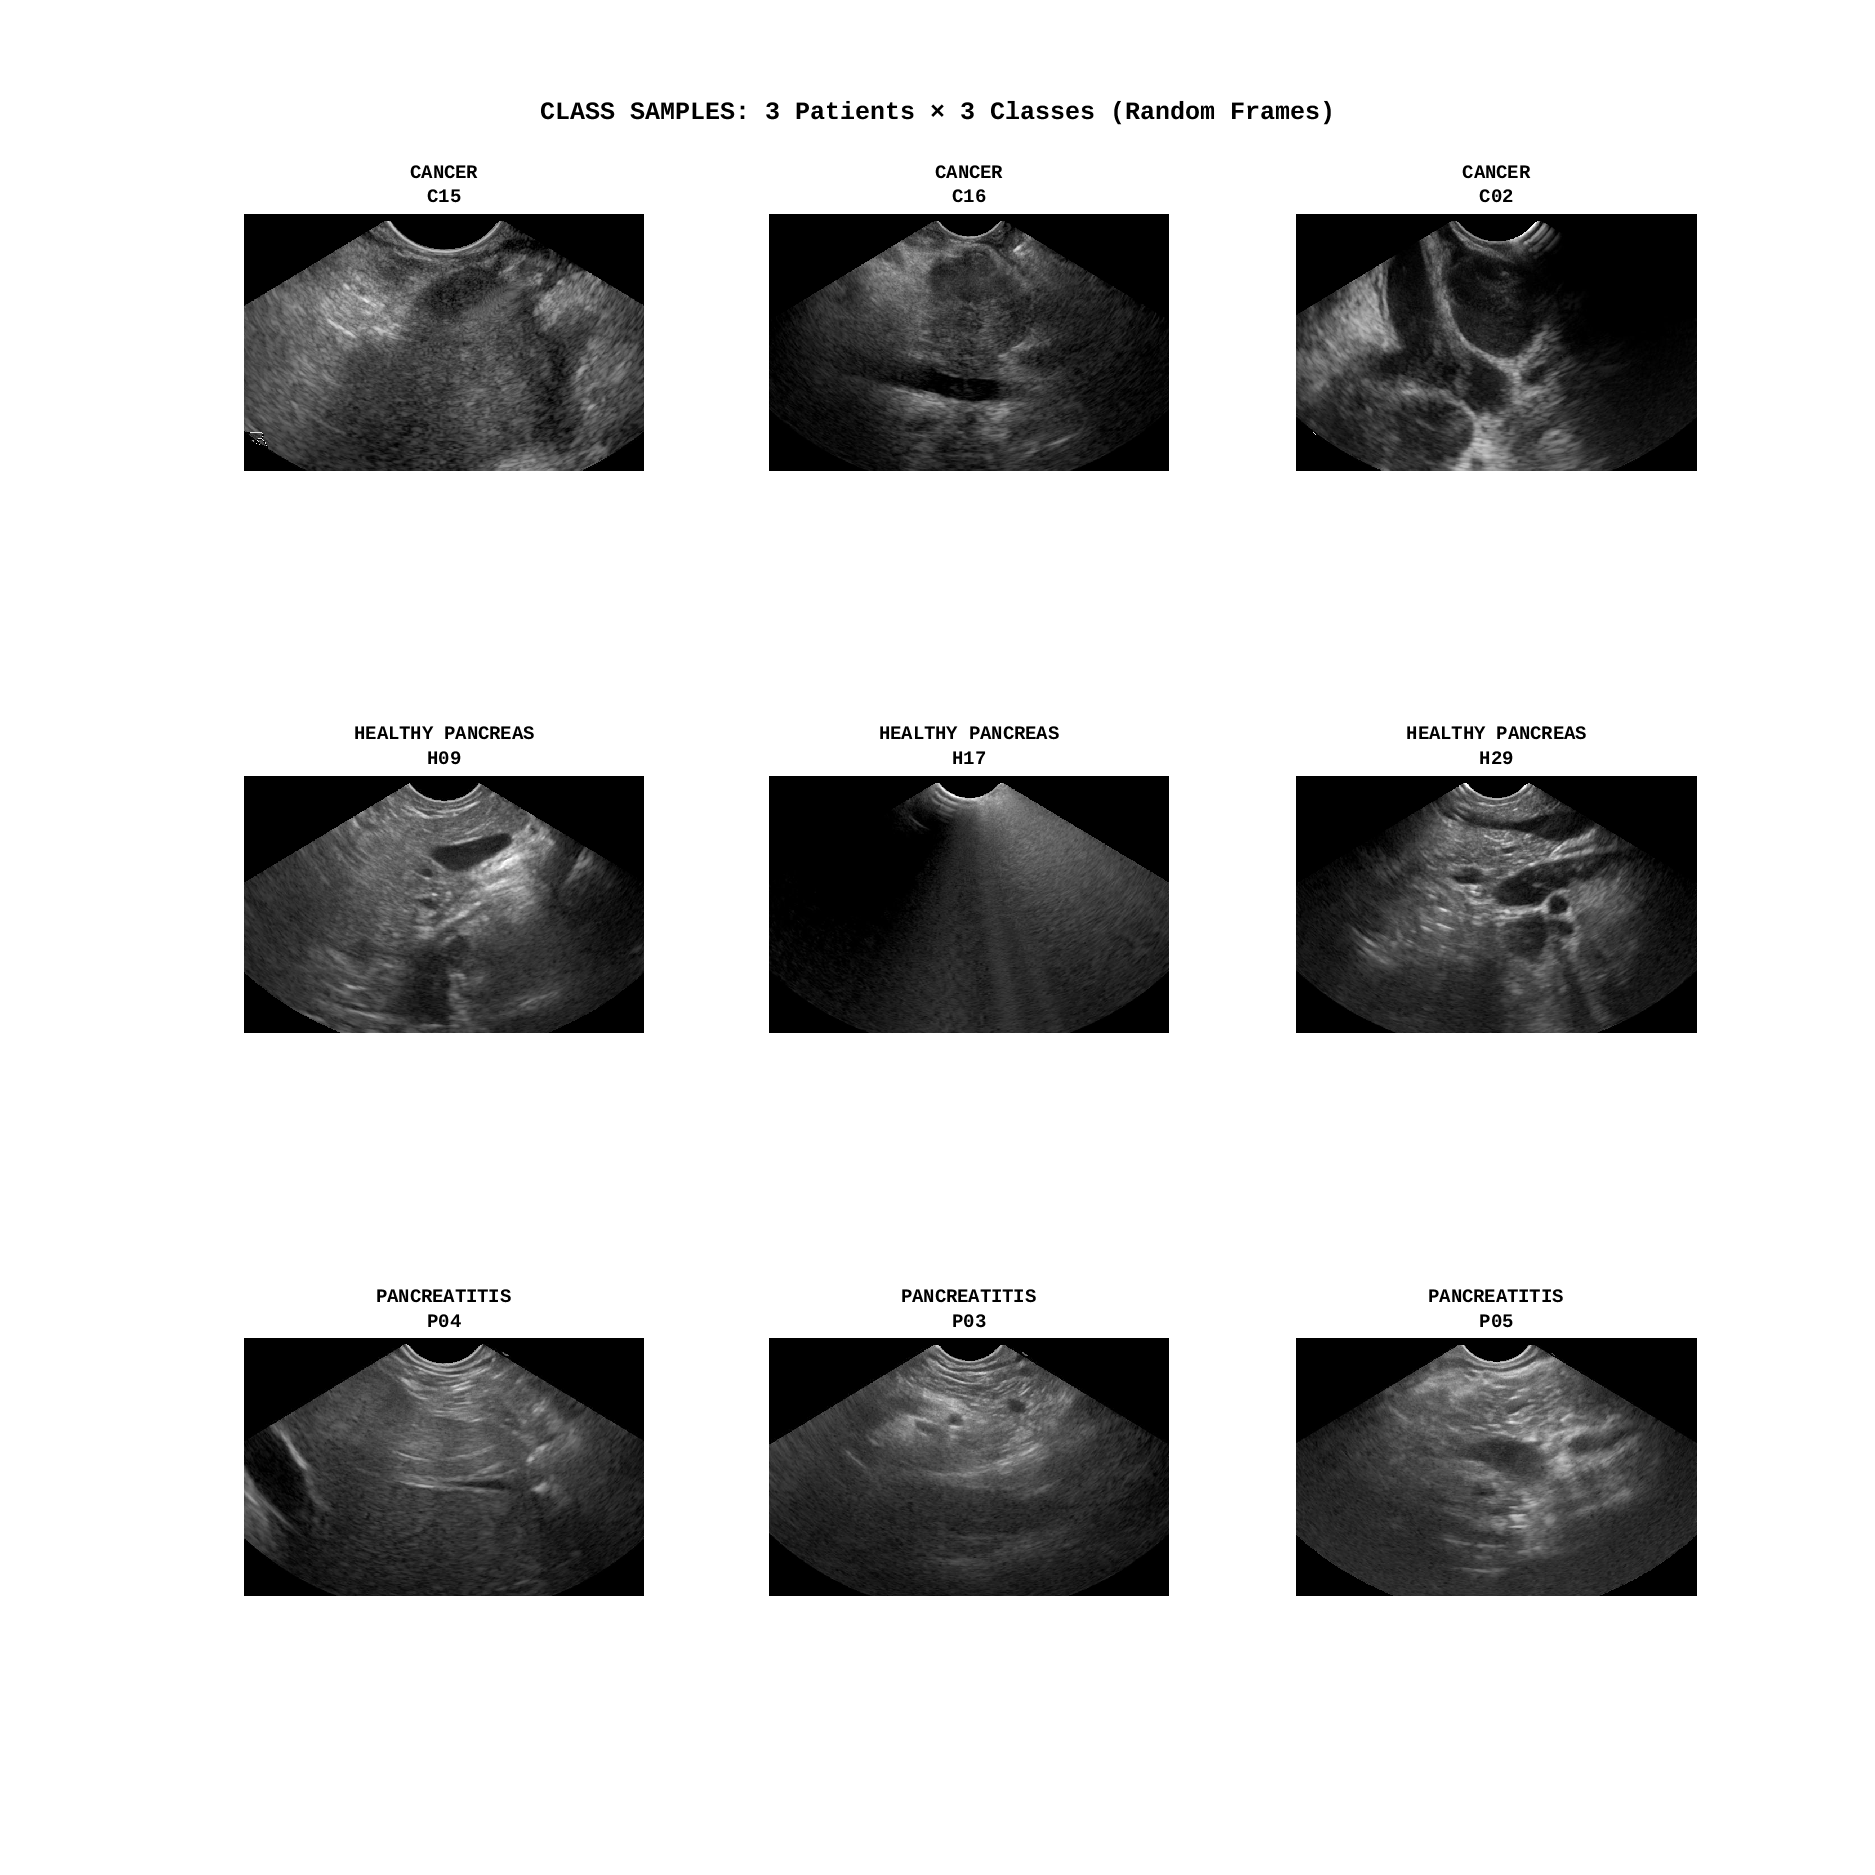

In [28]:
from IPython.display import Image, display
display(Image('/content/class_grid_3x3.png'))


In [29]:
%%bash
cat > /content/comprehensive_dashboard_fixed.m << 'EOF'
%% COMPREHENSIVE VISUALIZATION DASHBOARD (FIXED)
clear; clc; close all;

fprintf('\nGENERATING DATASET DASHBOARD (FIXED)\n');
fprintf('=====================================\n\n');

% ---------- COUNTS ----------
train_tbl = readtable('/content/pancreatic-cancer-fpga/data/train_split_simple.csv');
val_tbl   = readtable('/content/pancreatic-cancer-fpga/data/val_split_simple.csv');
test_tbl  = readtable('/content/pancreatic-cancer-fpga/data/test_split_simple.csv');

train_n = height(train_tbl);
val_n   = height(val_tbl);
test_n  = height(test_tbl);
total_n = train_n + val_n + test_n;

% ---------- FIGURE 1: PIE + BAR ----------
fig1 = figure('Position', [100, 100, 1800, 700]);  % bigger canvas

% Pie 1: Split distribution
subplot(1,3,1);
split_sizes = [train_n, val_n, test_n];
split_pcts  = split_sizes / total_n * 100;
p1 = pie(split_sizes);
title('TRAIN / VAL / TEST SPLIT', ...
      'FontSize', 14, 'FontWeight', 'bold', ...
      'Units','normalized','Position',[0.5, 1.10, 0]);  % move title up
tx = findobj(p1,'Type','text');
set(tx, 'FontSize', 11);

% Pie 2: Class distribution (TRAIN)
subplot(1,3,2);
class_dist = groupcounts(train_tbl, 'label');
class_counts = class_dist.GroupCount;
class_names  = class_dist.label;
p2 = pie(class_counts);
title('CLASS DISTRIBUTION (TRAIN)', ...
      'FontSize', 14, 'FontWeight', 'bold', ...
      'Units','normalized','Position',[0.5, 1.10, 0]);
tx2 = findobj(p2,'Type','text');
set(tx2, 'FontSize', 11);

% Bar chart: class counts per split
subplot(1,3,3);
train_dist = groupcounts(train_tbl, 'label');
val_dist   = groupcounts(val_tbl, 'label');
test_dist  = groupcounts(test_tbl, 'label');

bar_data = [train_dist.GroupCount, val_dist.GroupCount, test_dist.GroupCount];
b = bar(bar_data);
set(gca,'XTickLabel', train_dist.label, 'FontSize', 11);
ylabel('Image Count');
legend({'Train','Val','Test'}, 'Location','northoutside','Orientation','horizontal');
title('CLASS COUNTS BY SPLIT', 'FontSize', 14, 'FontWeight', 'bold');
grid on;

saveas(fig1, '/content/dashboard_pies_fixed.png');
fprintf('Saved: dashboard_pies_fixed.png\n');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/comprehensive_dashboard_fixed.m')"



GENERATING DATASET DASHBOARD (FIXED)

[Warning: MATLAB has disabled some advanced graphics rendering features by
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>.] 
Saved: dashboard_pies_fixed.png


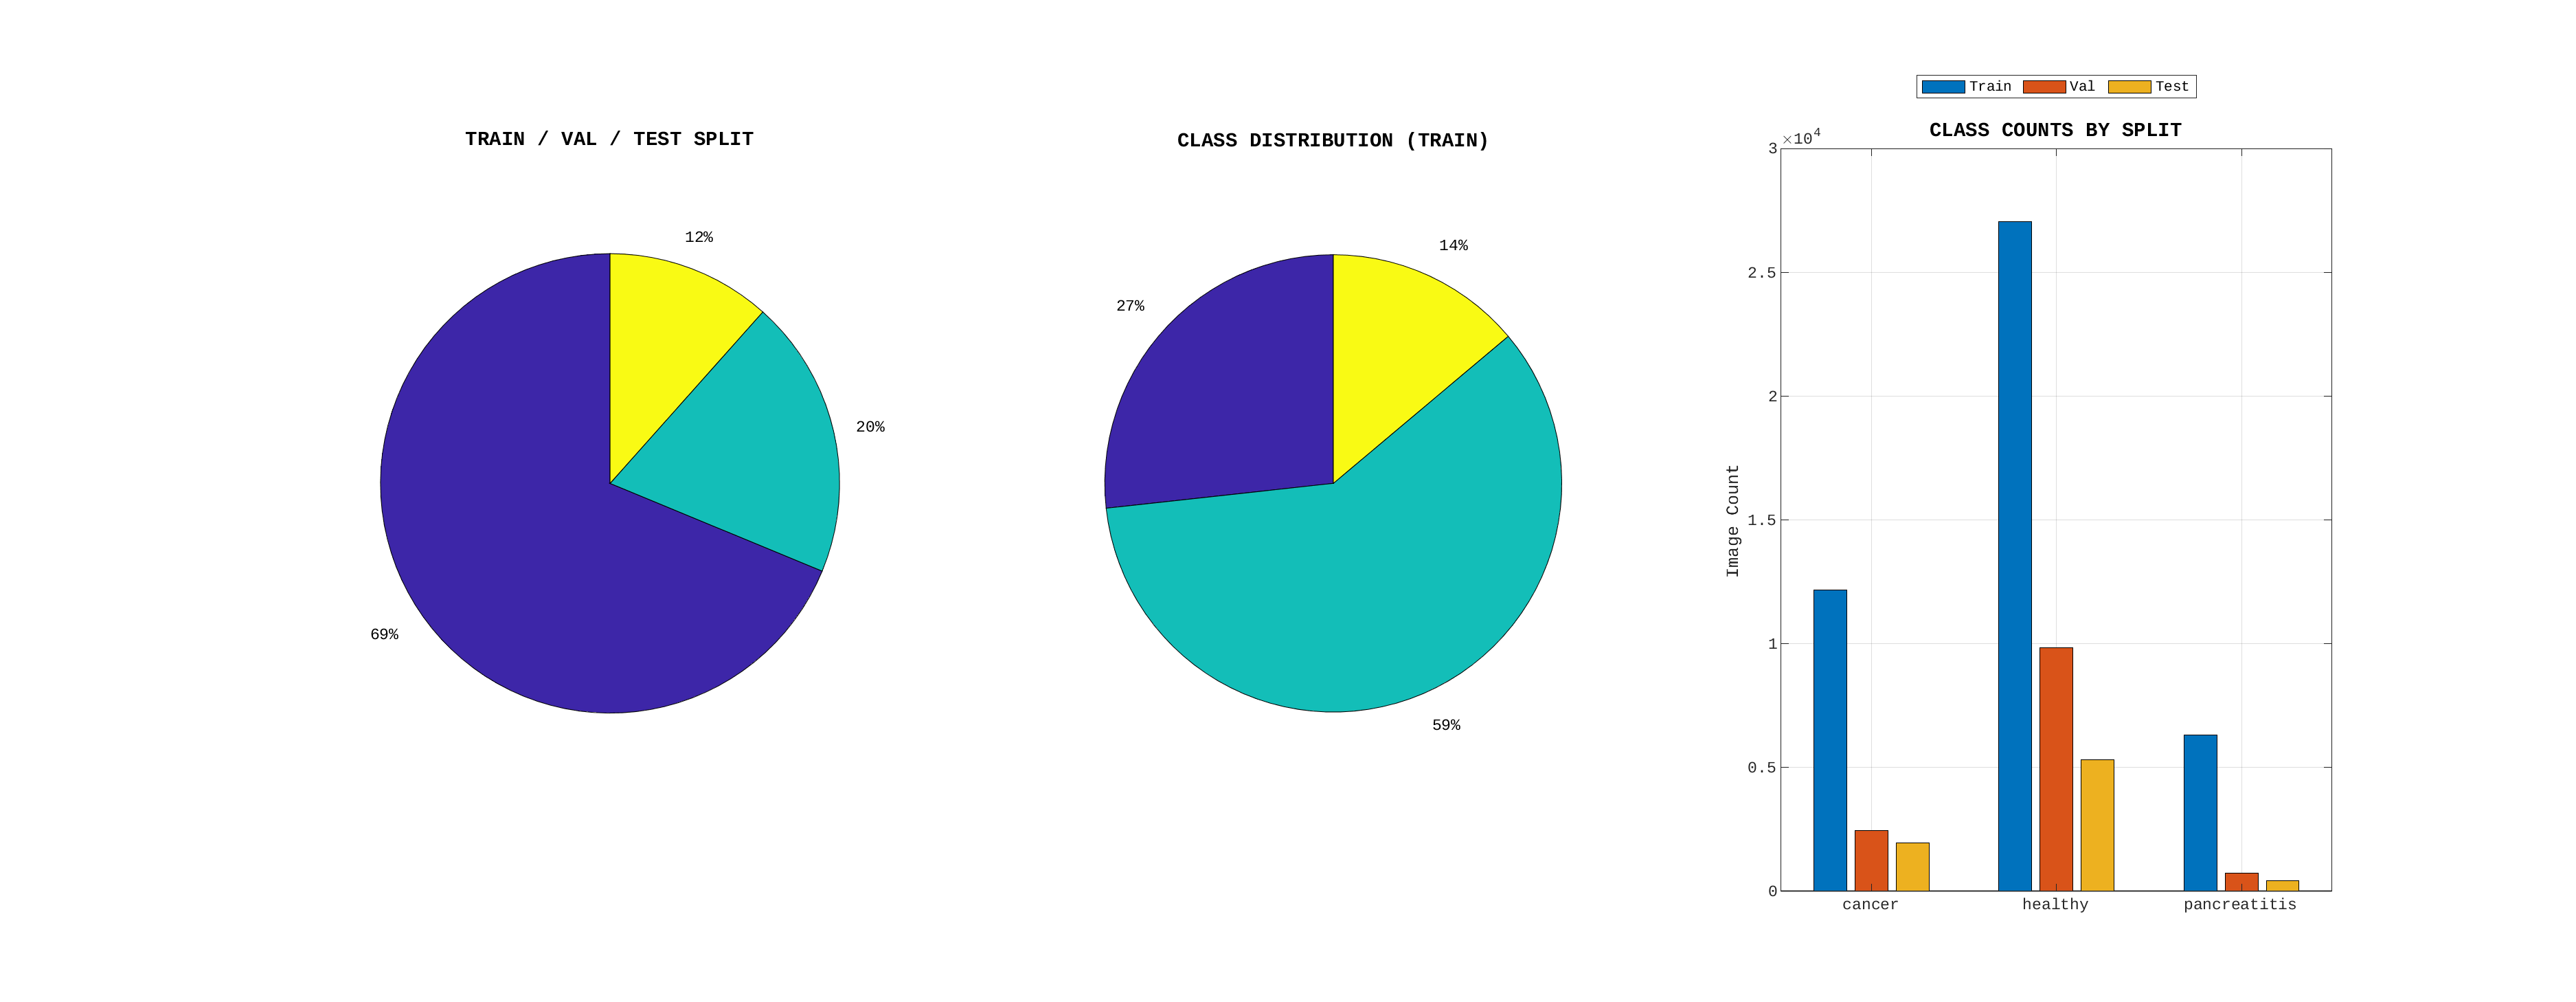


2️⃣ 3×3 CLASS SAMPLES GRID:


FileNotFoundError: No such file or directory: '/content/dashboard_grid.png'

FileNotFoundError: No such file or directory: '/content/dashboard_grid.png'

<IPython.core.display.Image object>


✅ Dashboard Complete! Ready for Sprint 2 Training.


In [30]:
from IPython.display import Image, display

display(Image('/content/dashboard_pies_fixed.png'))


print("\n2️⃣ 3×3 CLASS SAMPLES GRID:")
display(Image('/content/dashboard_grid.png'))

print("\n✅ Dashboard Complete! Ready for Sprint 2 Training.")


#data pre proceessing

In [31]:
%%bash
cat > /content/preprocess_eus.m << 'EOF'
%% PREPROCESS_EUS - Preprocessing function for EUS images
% Input: filepath (string)
% Output: img (224x224x3 single precision)
% Clinical Rationale: Standardize all images for ResNet-18 input

function img = preprocess_eus(filepath)
    % Read image (grayscale)
    img = imread(filepath);

    % Handle color/grayscale conversion
    if size(img, 3) == 3
        % If RGB, convert to grayscale
        img = rgb2gray(img);
    end

    % Resize to 224x224 (ResNet-18 standard input)
    img = imresize(img, [224 224], 'bilinear');

    % OPTION A: Duplicate grayscale to 3-channel RGB
    % (Current approach - uses pretrained ResNet weights)
    img = cat(3, img, img, img);

    % OPTION B: Keep 1-channel (requires modifying ResNet input layer)
    % Uncomment below and comment above line if using modified ResNet
    % img = img; % Keep as single channel

    % Normalize to single precision in [0, 1]
    img = im2single(img);
end
EOF

echo "✅ preprocess_eus.m created"


✅ preprocess_eus.m created


In [32]:
%%bash
cat > /content/section2_grid.m << 'EOF'
%% SECTION 2: BEFORE vs AFTER PREPROCESSING (3 Classes)
clear; clc; close all;

fprintf('\n=== SECTION 2: BEFORE vs AFTER PREPROCESSING ===\n');

base_dir = '/content/drive/MyDrive/Ecoendoscopy Database';
classes = {'CANCER', 'HEALTHY PANCREAS', 'PANCREATITIS'};

fig = figure('Position', [100, 100, 1200, 800]);
tile = 1;

for class_i = 1:3
    class_path = fullfile(base_dir, classes{class_i}, 'Original Images');
    patients = dir(class_path);
    patients = patients([patients.isdir] & ~ismember({patients.name}, {'.', '..'}));

    if isempty(patients)
        fprintf('⚠️ No patients in %s\n', classes{class_i});
        continue;
    end

    % Pick one random patient for this class
    p_idx = randi(length(patients));
    patient_folder = fullfile(class_path, patients(p_idx).name);
    imgs = dir(fullfile(patient_folder, '*.*'));

    % Find valid image files
    valid_imgs = {};
    for k = 1:length(imgs)
        if ~imgs(k).isdir
            [~, ~, ext] = fileparts(imgs(k).name);
            if ismember(lower(ext), {'.tif', '.jpg', '.png', '.bmp'})
                valid_imgs{end+1} = imgs(k).name;
            end
        end
    end

    if isempty(valid_imgs)
        fprintf('⚠️ No images in %s\n', patient_folder);
        continue;
    end

    % Pick one random frame
    img_name = valid_imgs{randi(length(valid_imgs))};
    img_path = fullfile(patient_folder, img_name);

    % -------- BEFORE PREPROCESSING --------
    raw = imread(img_path);
    subplot(2, 3, tile);
    imshow(raw, []);
    title({classes{class_i}; 'BEFORE preprocessing'}, ...
          'FontSize', 10, 'Interpreter','none');
    xlabel(sprintf('Patient: %s  |  Without resize / norm', patients(p_idx).name), ...
           'FontSize', 8, 'Interpreter','none');
    axis off;

    % -------- AFTER PREPROCESSING --------
    proc = preprocess_eus(img_path);   % uses your Section 1 function
    subplot(2, 3, tile + 3);
    imshow(proc, []);
    title({'AFTER preprocessing'; '224×224, normalized'}, ...
          'FontSize', 10);
    xlabel('With resize + 1→3 channels', 'FontSize', 8);
    axis off;

    tile = tile + 1;
end

sgtitle('BEFORE vs AFTER PREPROCESSING – EUS SAMPLES (Cancer / Healthy / Pancreatitis)', ...
        'FontSize', 14, 'FontWeight', 'bold');

saveas(fig, '/content/section2_grid.png');
fprintf('✅ Saved: section2_grid.png (before/after grid)\n');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/section2_grid.m')"



=== SECTION 2: BEFORE vs AFTER PREPROCESSING ===
[Warning: MATLAB has disabled some advanced graphics rendering features by
switching to software OpenGL. For more information, click <a
href="matlab:opengl('problems')">here</a>.] 
✅ Saved: section2_grid.png (before/after grid)


In [33]:
%%bash
cat > /content/section3_imbalance.m << 'EOF'
%% SECTION 3: IMBALANCE ANALYSIS & MITIGATION STRATEGY
clear; clc; close all;

fprintf('\n=== SECTION 3: CLASS IMBALANCE FIX ===\n');
fprintf('==========================================\n\n');

% Load original splits
train_tbl = readtable('/content/pancreatic-cancer-fpga/data/train_split_simple.csv');
val_tbl   = readtable('/content/pancreatic-cancer-fpga/data/val_split_simple.csv');
test_tbl  = readtable('/content/pancreatic-cancer-fpga/data/test_split_simple.csv');

% Compute original class distributions
fprintf('ORIGINAL CLASS DISTRIBUTION:\n');
fprintf('─────────────────────────────\n');

train_dist = groupcounts(train_tbl, 'label');
val_dist   = groupcounts(val_tbl, 'label');
test_dist  = groupcounts(test_tbl, 'label');

fprintf('\nTRAIN SET:\n');
for i = 1:height(train_dist)
    class_name = train_dist.label{i};
    count = train_dist.GroupCount(i);
    pct = (count / height(train_tbl)) * 100;
    fprintf('  %s: %d (%.1f%%)\n', class_name, count, pct);
end

fprintf('\nVAL SET:\n');
for i = 1:height(val_dist)
    class_name = val_dist.label{i};
    count = val_dist.GroupCount(i);
    pct = (count / height(val_tbl)) * 100;
    fprintf('  %s: %d (%.1f%%)\n', class_name, count, pct);
end

fprintf('\n\nIMBALANCE MITIGATION STRATEGY:\n');
fprintf('──────────────────────────────\n');

% 1. CLASS WEIGHTS (for weighted loss)
fprintf('\n1️⃣ CLASS WEIGHTS (inverse frequency):\n');
total_train = height(train_tbl);
class_weights = struct();

for i = 1:height(train_dist)
    class_name = train_dist.label{i};
    count = train_dist.GroupCount(i);

    % Inverse frequency: weight = total / (n_classes * class_count)
    weight = total_train / (height(train_dist) * count);

    % Normalize so min weight = 1
    class_weights.(class_name) = weight;
    fprintf('   %s: %.2f\n', class_name, weight);
end

% Normalize
weights_array = [class_weights.cancer, class_weights.healthy, class_weights.pancreatitis];
weights_array = weights_array / min(weights_array); % Min = 1
fprintf('\n   NORMALIZED: cancer=%.2f, healthy=%.2f, pancreatitis=%.2f\n', ...
    weights_array(1), weights_array(2), weights_array(3));

% 2. AUGMENTATION STRATEGY
fprintf('\n2️⃣ TARGETED AUGMENTATION (for minority classes):\n');
fprintf('   Pancreatitis: Rotation ±15°, Horizontal flip, Translation ±5%%\n');
fprintf('   Cancer: Rotation ±10°, Horizontal flip\n');
fprintf('   Healthy: Minimal augmentation (sufficient samples)\n');

% 3. OVERSAMPLING STRATEGY
fprintf('\n3️⃣ OVERSAMPLING OF PANCREATITIS:\n');
panc_count = train_dist.GroupCount(strcmp(train_dist.label, 'pancreatitis'));
healthy_count = train_dist.GroupCount(strcmp(train_dist.label, 'healthy'));
target_ratio = 0.20; % Target 20% pancreatitis in effective dataset

oversample_factor = (healthy_count * target_ratio) / (panc_count * (1 - target_ratio));
fprintf('   Current pancreatitis: %d\n', panc_count);
fprintf('   Oversample factor: %.2f (repeat each pancreatitis image ~%.0f times)\n', ...
    oversample_factor, oversample_factor);

fprintf('\n\nTRADE-OFFS:\n');
fprintf('────────────\n');
fprintf('  + Class weights: Reduces bias toward dominant class\n');
fprintf('  - Class weights: Too aggressive → unstable training\n');
fprintf('  + Augmentation: Increases diversity without data loss\n');
fprintf('  - Augmentation: Risk of unrealistic synthetic patterns\n');
fprintf('  + Oversampling: Balanced batches\n');
fprintf('  - Oversampling: Overfitting risk on minority class\n');
fprintf('  RECOMMENDATION: Combine all three with moderate settings\n');

fprintf('\n✅ SECTION 3 COMPLETE\n');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/section3_imbalance.m')"



=== SECTION 3: CLASS IMBALANCE FIX ===

ORIGINAL CLASS DISTRIBUTION:
─────────────────────────────

TRAIN SET:
  cancer: 12179 (26.7%)
  healthy: 27055 (59.4%)
  pancreatitis: 6322 (13.9%)

VAL SET:
  cancer: 2441 (18.8%)
  healthy: 9834 (75.6%)
  pancreatitis: 740 (5.7%)


IMBALANCE MITIGATION STRATEGY:
──────────────────────────────

1️⃣ CLASS WEIGHTS (inverse frequency):
   cancer: 1.25
   healthy: 0.56
   pancreatitis: 2.40

   NORMALIZED: cancer=2.22, healthy=1.00, pancreatitis=4.28

2️⃣ TARGETED AUGMENTATION (for minority classes):
   Pancreatitis: Rotation ±15°, Horizontal flip, Translation ±5%
   Cancer: Rotation ±10°, Horizontal flip
   Healthy: Minimal augmentation (sufficient samples)

3️⃣ OVERSAMPLING OF PANCREATITIS:
   Current pancreatitis: 6322
   Oversample factor: 1.07 (repeat each pancreatitis image ~1 times)


TRADE-OFFS:
────────────
  + Class weights: Reduces bias toward dominant class
  - Class weights: Too aggressive → unstable training
  + Augmentation: Increas

In [ ]:
%%bash
cat > /content/section4_datastores.m << 'EOF'
%% SECTION 4: CREATE DATASTORES WITH PREPROCESSING & AUGMENTATION
clear; clc; close all;

fprintf('\n=== SECTION 4: DATASTORE CREATION ===\n');
fprintf('=======================================\n\n');

% Load CSV tables
train_tbl = readtable('/content/pancreatic-cancer-fpga/data/train_split_simple.csv');
val_tbl   = readtable('/content/pancreatic-cancer-fpga/data/val_split_simple.csv');
test_tbl  = readtable('/content/pancreatic-cancer-fpga/data/test_split_simple.csv');

% ========== PREPROCESSING FUNCTION ==========
readFcn = @(filepath) preprocess_eus(filepath);

% ========== TRAINING DATASTORE (with oversampling + augmentation) ==========
fprintf('1️⃣ Building TRAINING datastore:\n');

% Oversample pancreatitis (repeat paths)
train_paths = train_tbl.image_path;
train_labels = categorical(train_tbl.label);

% Find pancreatitis indices
panc_idx = find(train_labels == 'pancreatitis');
cancer_idx = find(train_labels == 'cancer');
healthy_idx = find(train_labels == 'healthy');

fprintf('   Original counts: cancer=%d, healthy=%d, pancreatitis=%d\n', ...
    length(cancer_idx), length(healthy_idx), length(panc_idx));

% Oversample pancreatitis ~2.5x
oversample_factor = 2.5;
panc_oversample_idx = repmat(panc_idx, ceil(oversample_factor), 1);
panc_oversample_idx = panc_oversample_idx(1:round(length(panc_idx) * oversample_factor));

% Combine all
combined_idx = [healthy_idx; cancer_idx; panc_oversample_idx];
train_paths_combined = train_paths(combined_idx);
train_labels_combined = train_labels(combined_idx);

fprintf('   After oversampling: cancer=%d, healthy=%d, pancreatitis=%d\n', ...
    sum(train_labels_combined == 'cancer'), ...
    sum(train_labels_combined == 'healthy'), ...
    sum(train_labels_combined == 'pancreatitis'));

% Create base datastore (has .Labels property)
imdsTrain = imageDatastore(train_paths_combined, 'Labels', train_labels_combined, ...
    'ReadFcn', readFcn);

% ✅ CRITICAL: Save shuffled base BEFORE augmentation wrapper
imdsTrainBase = shuffle(imdsTrain);

% Add augmentation wrapper (this does NOT have .Labels)
aug = imageDataAugmenter(...
    'RandRotation', [-15 15], ...
    'RandXReflection', true, ...
    'RandXTranslation', [-0.05 0.05], ...
    'RandYTranslation', [-0.05 0.05]);

imdsTrainAug = augmentedImageDatastore([224 224], imdsTrainBase, ...
    'DataAugmentation', aug);

fprintf('   ✅ Training datastore ready (shuffled + augmented)\n');

% ========== VALIDATION DATASTORE (no augmentation) ==========
fprintf('\n2️⃣ Building VALIDATION datastore:\n');
imdsVal = imageDatastore(val_tbl.image_path, 'Labels', categorical(val_tbl.label), ...
    'ReadFcn', readFcn);
imdsVal = shuffle(imdsVal);
fprintf('   ✅ Validation datastore ready\n');

% ========== TEST DATASTORE (no augmentation) ==========
fprintf('\n3️⃣ Building TEST datastore:\n');
imdsTest = imageDatastore(test_tbl.image_path, 'Labels', categorical(test_tbl.label), ...
    'ReadFcn', readFcn);
fprintf('   ✅ Test datastore ready\n');

% ✅ CRITICAL: Save imdsTrainBase for label extraction in training script
save('/content/datastores.mat', 'imdsTrainBase', 'imdsTrainAug', 'imdsVal', 'imdsTest');
fprintf('\n✅ All datastores saved to datastores.mat\n');
fprintf('   Includes: imdsTrainBase (for labels), imdsTrainAug (for training)\n');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/section4_datastores.m')"


In [ ]:
%%bash
cat > /content/section5_verify.m << 'EOF'
%% SECTION 5: VERIFY IMBALANCE CORRECTION
clear; clc; close all;

fprintf('\n=== SECTION 5: IMBALANCE CORRECTION VERIFICATION ===\n');
fprintf('=====================================================\n\n');

% Load original tables
train_tbl = readtable('/content/pancreatic-cancer-fpga/data/train_split_simple.csv');

% Original distribution
fprintf('BEFORE IMBALANCE FIX:\n');
fprintf('──────────────────────\n');
orig_dist = groupcounts(train_tbl, 'label');
orig_counts = orig_dist.GroupCount;
orig_pcts = (orig_counts / sum(orig_counts)) * 100;

for i = 1:height(orig_dist)
    fprintf('  %s: %d (%.1f%%)\n', orig_dist.label{i}, orig_counts(i), orig_pcts(i));
end

% After oversampling (2.5x pancreatitis)
fprintf('\n\nAFTER IMBALANCE FIX (2.5x oversampling):\n');
fprintf('─────────────────────────────────────────\n');

panc_original = orig_counts(strcmp(orig_dist.label, 'pancreatitis'));
cancer_original = orig_counts(strcmp(orig_dist.label, 'cancer'));
healthy_original = orig_counts(strcmp(orig_dist.label, 'healthy'));

panc_after = round(panc_original * 2.5);
fixed_counts = [cancer_original, healthy_original, panc_after];
fixed_pcts = (fixed_counts / sum(fixed_counts)) * 100;

fprintf('  cancer: %d (%.1f%%)\n', cancer_original, fixed_pcts(1));
fprintf('  healthy: %d (%.1f%%)\n', healthy_original, fixed_pcts(2));
fprintf('  pancreatitis: %d (%.1f%%)\n', panc_after, fixed_pcts(3));

% ========== BEFORE vs AFTER PIE CHARTS ==========
fig = figure('Position', [100, 100, 1400, 600]);

% BEFORE
subplot(1,2,1);
p1 = pie(orig_counts, ...
    {sprintf('cancer\n%.1f%%\n(%d)', orig_pcts(1), orig_counts(1)), ...
     sprintf('healthy\n%.1f%%\n(%d)', orig_pcts(2), orig_counts(2)), ...
     sprintf('pancreatitis\n%.1f%%\n(%d)', orig_pcts(3), orig_counts(3))});
title('BEFORE: Original Imbalance', 'FontSize', 13, 'FontWeight', 'bold', ...
    'Units','normalized','Position',[0.25, 1.10, 0]);
tx1 = findobj(p1,'Type','text');
set(tx1, 'FontSize', 11);

% AFTER
subplot(1,2,2);
p2 = pie(fixed_counts, ...
    {sprintf('cancer\n%.1f%%\n(%d)', fixed_pcts(1), fixed_counts(1)), ...
     sprintf('healthy\n%.1f%%\n(%d)', fixed_pcts(2), fixed_counts(2)), ...
     sprintf('pancreatitis\n%.1f%%\n(%d)', fixed_pcts(3), fixed_counts(3))});
title('AFTER: Imbalance Fixed (2.5x oversample)', 'FontSize', 13, 'FontWeight', 'bold', ...
    'Units','normalized','Position',[0.75, 1.10, 0]);
tx2 = findobj(p2,'Type','text');
set(tx2, 'FontSize', 11);

sgtitle('BEFORE vs AFTER: Imbalance Correction', 'FontSize', 14, 'FontWeight', 'bold');

saveas(fig, '/content/section5_before_after.png');
fprintf('\n✅ Saved: section5_before_after.png\n');

% Summary
fprintf('\n\nIMBALANCE CORRECTION SUMMARY:\n');
fprintf('─────────────────────────────\n');
ratio_before = max(orig_pcts) / min(orig_pcts);
ratio_after = max(fixed_pcts) / min(fixed_pcts);
fprintf('  Imbalance ratio BEFORE: %.2f:1\n', ratio_before);
fprintf('  Imbalance ratio AFTER:  %.2f:1\n', ratio_after);
fprintf('  Improvement: %.1f%% reduction in imbalance\n', (1 - ratio_after/ratio_before)*100);

if ratio_after <= 3.0
    fprintf('  ✅ TARGET ACHIEVED: Ratio ≤ 3:1\n');
else
    fprintf('  ⚠️ Still imbalanced. Consider increasing oversample factor.\n');
end

fprintf('\n✅ SECTION 5 COMPLETE\n');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/section5_verify.m')"


In [ ]:
from IPython.display import Image, display

print("=" * 70)
print("🩺 EUS IMAGE PREPROCESSING & IMBALANCE FIX - COMPLETE PIPELINE")
print("=" * 70)

print("\n=== VISUAL CHECK: BEFORE vs AFTER PREPROCESSING ===")
display(Image('/content/section2_grid.png'))

print("\n\n### SECTION 5: BEFORE vs AFTER IMBALANCE FIX")
display(Image('/content/section5_before_after.png'))

print("\n✅ Pipeline complete! Ready for Sprint 2 training.")


#  DAG pipeline setup


In [ ]:
%%bash
cat > /content/verify_datastores.m << 'EOF'
function status = verify_datastores()
    try
        load('/content/datastores.mat');
        fprintf('✅ Train: %d files OK\n', numel(imdsTrainAug.Files));
        fprintf('✅ Val: %d files OK\n', numel(imdsVal.Files));
        fprintf('✅ Test: %d files OK\n', numel(imdsTest.Files));

        % Verify first files exist on disk
        if exist(imdsTrainAug.Files{1}, 'file') && ...
           exist(imdsVal.Files{1}, 'file') && ...
           exist(imdsTest.Files{1}, 'file')
            fprintf('✅ FIRST FILES ACCESSIBLE\n');
            status = true;
        else
            fprintf('❌ FILES MISSING\n');
            status = false;
        end
    catch ME
        fprintf('❌ LOAD FAILED: %s\n', ME.message);
        status = false;
    end
end
EOF
echo "✅ verify_datastores.m CREATED"
ls -la /content/verify_datastores.m


In [ ]:
%%bash
cat > /content/build_cnn_layers.m << 'EOF'
function layers = build_cnn_layers()
    layers = [
        imageInputLayer([224 224 3],'Name','input')
        convolution2dLayer(3,16,'Padding','same','Name','conv1')
        reluLayer('Name','relu1')
        maxPooling2dLayer(2,'Stride',2,'Name','pool1')
        convolution2dLayer(3,32,'Padding','same','Name','conv2')
        reluLayer('Name','relu2')
        globalAveragePooling2dLayer('Name','gapool')
        fullyConnectedLayer(3,'Name','fc')
        softmaxLayer('Name','softmax')
        classificationLayer('Name','classoutput')
    ];

    % Save for HDL Coder compatibility
    save('/content/cnn_layers.mat', 'layers');
    fprintf('✅ CNN layers saved: %d layers\n', numel(layers));
    fprintf('✅ HDL-ready architecture complete\n');
end
EOF
echo "✅ build_cnn_layers.m CREATED"
ls -la /content/build_cnn_layers.m


In [ ]:
%%bash
cat > /content/train_cnn_model.m << 'EOF'
function net = train_cnn_model(epochs)
    load('/content/datastores.mat');
    load('/content/cnn_layers.mat');
    options = trainingOptions('sgdm', ...
        'InitialLearnRate',0.01, ...
        'MaxEpochs',epochs, ...
        'MiniBatchSize',32, ...
        'ValidationData',imdsVal, ...
        'Plots','none', ...
        'Verbose',true, ...
        'ExecutionEnvironment','gpu');
    tic;
    net = trainNetwork(imdsTrainAug, layers, options);
    fprintf('✅ Training time: %.1f min\n', toc/60);
    save('/content/trained_cnn.mat', 'net');
end
EOF
echo "✅ train_cnn_model.m CREATED"
ls -la /content/train_cnn_model.m


In [ ]:
%%bash
cat > /content/evaluate_cnn_model.m << 'EOF'
function results = evaluate_cnn_model()
    try
        load('/content/trained_cnn.mat', 'net');
        load('/content/datastores.mat');
        fprintf('🔍 Evaluating on test set...\n');
        pred = classify(net, imdsTest);
        true_labels = imdsTest.Labels;
        acc = mean(pred == true_labels) * 100;
        [cm, classes] = confusionmat(true_labels, pred);

        fprintf('🏆 Test Accuracy: %.2f%%\n', acc);
        fprintf('Confusion Matrix:\n');
        disp(cm);
        fprintf('Classes: %s\n', mat2str(classes'));

        results = struct('accuracy', acc, 'predictions', pred, ...
                        'confusion_matrix', cm, 'classes', classes);
        save('/content/cnn_results.mat', 'results');
        fprintf('✅ Results saved to cnn_results.mat\n');
    catch ME
        fprintf('❌ Evaluation failed: %s\n', ME.message);
        results = [];
    end
end
EOF
echo "✅ evaluate_cnn_model.m CREATED"
ls -la /content/evaluate_cnn_model.m


In [ ]:
%%bash
# BULLETPROOF MASTER PIPELINE WITH FAIL-FAST
cat > /content/master_pipeline.m << 'EOF'
%% SPRINT 2 FAIL-FAST MASTER PIPELINE
clear; clc; fprintf('🚀 SPRINT 2 STARTING...\n');

try
    % STEP 1: Data verification
    fprintf('📊 [STEP 1] Verifying datastores...\n');
    status = verify_datastores();
    if ~status
        error('STEP 1 FAILED: datastores.mat invalid');
    end
    fprintf('✅ STEP 1 OK\n');

    % STEP 2: Build CNN
    fprintf('🧠 [STEP 2] Building CNN layers...\n');
    layers = build_cnn_layers();
    if ~exist('/content/cnn_layers.mat', 'file')
        error('STEP 2 FAILED: cnn_layers.mat not saved');
    end
    fprintf('✅ STEP 2 OK\n');

    % STEP 3: Train (most likely to fail)
    fprintf('⚡ [STEP 3] Training CNN...\n');
    if ~canUseGPU
        error('NO GPU AVAILABLE - Use Kaggle/GCP');
    end
    net = train_cnn_model(10);
    if ~exist('/content/trained_cnn.mat', 'file')
        error('STEP 3 FAILED: trained_cnn.mat not saved');
    end
    fprintf('✅ STEP 3 OK\n');

    % STEP 4: Evaluate
    fprintf('📈 [STEP 4] Evaluating...\n');
    results = evaluate_cnn_model();
    if isempty(results)
        error('STEP 4 FAILED: evaluation error');
    end
    fprintf('✅ STEP 4 OK - Accuracy: %.1f%%\n', results.accuracy);

    fprintf('🎉 SPRINT 2 SUCCESS!\n');

catch ME
    fprintf('❌ PIPELINE FAILED at:\n');
    fprintf('ERROR: %s\n', ME.message);
    fprintf('LINE: %d\n', ME.stack(1).line);
    exit(1);  % Force MATLAB exit with error code
end
EOF

echo "✅ FAIL-FAST master_pipeline.m CREATED"
ls -la /content/master_pipeline.m


In [ ]:
%%bash
# Create single executable script with paths
cat > /content/run_step1_2.m << 'EOF'
addpath('/content');
verify_datastores();
build_cnn_layers();
fprintf('✅ STEP 1+2 COMPLETE\n');
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/run_step1_2.m')"
ls -la /content/*.mat


In [ ]:
%%bash
# Test Step 4 error handling (uses dummy trained_cnn.mat)
cat > /content/run_step4_test.m << 'EOF'
addpath('/content');
try
    fprintf('🧪 Testing Step 4 error handling...\n');
    results = evaluate_cnn_model();  % Should FAIL (no trained_cnn.mat)
    fprintf('✅ Step 4 PASSED (should not print)\n');
catch ME
    fprintf('✅ ERROR HANDLING WORKS: %s\n', ME.message);
end
EOF

export MLM_LICENSE_FILE=/opt/matlab/licenses/license.lic
export LD_LIBRARY_PATH=/opt/matlab/bin/glnxa64:$LD_LIBRARY_PATH
/opt/matlab/bin/matlab -batch "run('/content/run_step4_test.m')"
